In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
# !cp -r /kaggle/input/gameplay-prediction-src/gameplay_prediction_src/* .

In [4]:
import torch
import argparse
import platform
import pickle
# from args import parse_args
from models import trainer
from data.dataloader import Preprocess, get_target, get_loaders
from utils import setSeeds
from sklearn.preprocessing import OrdinalEncoder, RobustScaler

import pdb

In [5]:
parser = argparse.ArgumentParser()

parser.add_argument("--seed", default=42, type=int, help="seed")

parser.add_argument("--device", default="cpu", type=str, help="cpu or gpu")


# Data
parser.add_argument(
    "--data_dir",
    default= "data/raw/input/",
    type=str,
    help="data directory",
)

parser.add_argument(
    "--processed_dir", 
    default= "data/processed/",
    type=str, help="processed data directory"
)

parser.add_argument(
    "--file_name", default="train.parquet", type=str, help="train file name"
)

parser.add_argument(
    "--target_name", default="train_labels.csv", type=str, help="target file name"
)

parser.add_argument(
    "--processed", default=0, type=int, help='whether input data is processed or not'
)

parser.add_argument(
    "--test_file_name", default="test.parquet", type=str, help="test file name"
)

parser.add_argument(
    "--num_cols", default=['elapsed_time', 'level'], type=list, help="numeric(continuous) columns"
)

parser.add_argument(
    "--cate_cols", default=['event_name', 'name', 'fqid', 'room_fqid', 'text_fqid'], type=list, help="categorical columns"
)


# model
parser.add_argument(
    "--model_dir", default="models/", type=str, help="model directory"
)
parser.add_argument(
    "--model_name", default="model.pt", type=str, help="model file name"
)

parser.add_argument(
    "--output_dir", default="output/", type=str, help="output directory"
)


parser.add_argument(
    "--max_seq_len", default=2000, type=int, help="max sequence length"
)
parser.add_argument("--num_workers", default=1, type=int, help="number of workers")

# 모델
parser.add_argument(
    "--input_dim", default=64, type=int, help="input dimension size"
)
parser.add_argument(
    "--hidden_dim", default=16, type=int, help="hidden dimension size"
)
parser.add_argument(
    "--lstm_hidden_dim", default=8, type=int, help="lstm hidden dimension size"
)

parser.add_argument(
    "--projection_dim", default=8, type=int, help="hidden dimension size"
)
parser.add_argument("--n_layers", default=2, type=int, help="number of layers")
parser.add_argument("--n_heads", default=2, type=int, help="number of heads")
parser.add_argument("--drop_out", default=0.2, type=float, help="drop out rate")

# 훈련
parser.add_argument("--n_epochs", default=20, type=int, help="number of epochs")
parser.add_argument("--batch_size", default=64, type=int, help="batch size")
parser.add_argument("--lr", default=0.0001, type=float, help="learning rate")
parser.add_argument("--clip_grad", default=10, type=int, help="clip grad")
parser.add_argument("--patience", default=5, type=int, help="for early stopping")

parser.add_argument(
    "--log_steps", default=50, type=int, help="print log per n steps"
)

# 추론
parser.add_argument(
    "--is_infer", default=0, type=int, help="is inference"
)

### 중요 ###
parser.add_argument("--model", default="lstm", type=str, help="model type")
parser.add_argument("--optimizer", default="adam", type=str, help="optimizer type")
parser.add_argument(
    "--scheduler", default="plateau", type=str, help="scheduler type"
)

_StoreAction(option_strings=['--scheduler'], dest='scheduler', nargs=None, const=None, default='plateau', type=<class 'str'>, choices=None, required=False, help='scheduler type', metavar=None)

In [6]:
import torch.nn as nn
class DNN(nn.Module):
    def __init__(self, args):
        super(DNN, self).__init__()
        self.args = args
        self.init_n = None
        self.max_seq_len = self.args.max_seq_len
        self.col_len = len(self.args.num_cols) + len(self.args.cate_cols)
        self.batch_size = self.args.batch_size

        self.layer1 = nn.Linear(self.args.max_seq_len * self.col_len, 1024) 
        self.layer2 = nn.Linear(1024, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, 18)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        self.init_n = len(input[0])
        input = torch.stack(input[:-1]) # mask 제외
        batch_size = input[0].size(0)
        x = self.layer1(input.contiguous().view(batch_size, -1))
        x = self.relu(x)

        x = self.layer2(x)
        x = self.relu(x)

        x = self.layer3(x)
        x = self.relu(x)

        x = self.layer4(x)
        x = self.sigmoid(x)

        return x
        

class LSTM(nn.Module):
    def __init__(self, args):
        super(LSTM, self).__init__()
        self.args = args
        self.input_dim = self.args.input_dim
        self.hidden_dim = self.args.hidden_dim
        self.projection_dim = self.args.projection_dim
        self.n_layers = self.args.n_layers
        self.lstm_hidden_dim = self.args.lstm_hidden_dim
        self.cate_cols = self.args.cate_cols
        self.num_cols = self.args.num_cols
        
        # questions 결정
        qnum = [None, 3, 10, 5]
        self.questions = qnum[self.args.level_group]
        
        # embedding
        for cat_col in self.args.cate_cols:
            setattr(self,
                    'embedding_' + cat_col,
                    nn.Embedding(getattr(self.args, 'input_size_'+cat_col) + 2, self.hidden_dim)       
            )         # change +1 to +2
        
        
        # embedding combination projection
        self.cat_proj = nn.Linear(self.hidden_dim * len(self.args.cate_cols), 
                                   self.projection_dim // 2)
        
        
        if self.args.cate_cols:
            # layer normalization
            self.layernorm = nn.LayerNorm(self.projection_dim // 2)
            self.num_proj = nn.Linear(len(self.args.num_cols), 
                                  self.projection_dim // 2)
        else: 
            # layer normalization
            self.layernorm = nn.LayerNorm(self.projection_dim)
            self.num_proj = nn.Linear(len(self.args.num_cols), 
                                  self.projection_dim)
            
        # comb_proj + len(num_cols) into model
        self.lstm = nn.LSTM(
            self.projection_dim, self.lstm_hidden_dim, self.n_layers, batch_first=True
        )

        

        # Fully connected layer
        self.fc = nn.Linear(self.lstm_hidden_dim * self.args.max_seq_len, 128) # 맞춰야할 문제수
        self.fca = nn.Linear(128, self.questions)
        self.activation = nn.Sigmoid()
    
    def forward(self, input):
        
        # input 형태 : ['elapsed_time', 'level', 'event_name', 'name', 'fqid', 'room_fqid', 'text_fqid']
        # a = len(self.args.cate_cols)
        a = len(self.num_cols)
        num_data = input[:a]  # 왜 a 대신 len(self.num_cols)로 하면 안되는건지?
        cate_data = input[a:-1] # mask 제외
        # test, question, tag, _, mask, interaction = input

        # batch_size = interaction.size(0)
        batch_size = input[0].size(0)

        # Embedding
        # embed_event_name = self.embedding_event_name(event_name) 형식 
        
        # categorical embedding
        # concat all categorical + numerical
        num_data = torch.stack(num_data, 2) # list to tensor
        num_X = self.layernorm(self.num_proj(num_data))

        if self.cate_cols:
            cat_embed = torch.cat(
                [getattr(self, 'embedding_' + cat_col)(cate_data[i]) for i, cat_col in enumerate(self.cate_cols)],
                2,
            )
            cat_X = self.layernorm(self.cat_proj(cat_embed))
            X = torch.cat([num_X, cat_X], -1)
        else: X = num_X
        
        out, _ = self.lstm(X)
        out = out.contiguous().view(batch_size, -1)
        out = self.fc(out)
        out = self.fca(out)
        out = self.activation(out)
        return out

In [7]:
def run(args, train_data, valid_data, train_target, valid_target, model):
    train_loader, valid_loader = get_loaders(args, train_data, valid_data, train_target, valid_target)

    # only when using warmup scheduler
    args.total_steps = int(math.ceil(len(train_loader.dataset) / args.batch_size)) * (
        args.n_epochs
    )
    args.warmup_steps = args.total_steps // 10

    optimizer = get_optimizer(model, args)
    scheduler = get_scheduler(optimizer, args)

    best_f1 = -1
    early_stopping_counter = 0
    train_time = datetime.today().strftime("%Y%m%d%H%M%S")
    for epoch in range(args.n_epochs):

        print(f"Start Training: Epoch {epoch + 1}")

        ### TRAIN
        train_f1, train_auc, train_acc, train_loss = train(
            train_loader, model, optimizer, scheduler, args
        )

        ### VALID
        f1, auc, acc = validate(valid_loader, model, args)

        ### TODO: model save or early stopping
        # wandb.log(
        #     {
        #         "epoch": epoch,
        #         "train_loss_epoch": train_loss,
        #         "train_f1_epoch": train_f1,
        #         "train_auc_epoch": train_auc,
        #         "train_acc_epoch": train_acc,
        #         "valid_f1_epoch": f1,
        #         "valid_auc_epoch": auc,
        #         "valid_acc_epoch": acc,
        #     }
        # )
        if f1 > best_f1:
            best_f1 = f1
            # torch.nn.DataParallel로 감싸진 경우 원래의 model을 가져옵니다.
            model_to_save = model.module if hasattr(model, "module") else model
            save_checkpoint(
                {
                    "epoch": epoch + 1,
                    "state_dict": model_to_save.state_dict(),
                },
                args.model_dir,
                "model.pt",
                train_time,
                args
            )
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= args.patience:
                print(
                    f"EarlyStopping counter: {early_stopping_counter} out of {args.patience}"
                )
                break

        # scheduler
        if args.scheduler == "plateau":
            scheduler.step(best_f1)


def train(train_loader, model, optimizer, scheduler, args):
    model.train()

    total_preds = []
    total_targets = []
    losses = []
    for step, (batch, target) in tqdm(enumerate(train_loader)):
        input = list(map(lambda t: t.to(args.device), process_batch(batch)))
        preds = model(input)
        target = torch.Tensor(target).to(args.device)
        loss = compute_loss(preds, target)
        update_params(loss, model, optimizer, scheduler, args)

        if step % args.log_steps == 0:
            print(f"Training steps: {step} Loss: {str(loss.item())}")

        # predictions
        # preds = preds[:, -1]
        # targets = targets[:, -1]

        total_preds.append(preds.detach())
        total_targets.append(target.detach())
        losses.append(loss)

    total_preds = torch.concat(total_preds).cpu().numpy()
    total_targets = torch.concat(total_targets).cpu().numpy()

    # Train AUC / ACC
    f1, pre, rec, auc, acc = get_metric(total_targets, total_preds)
    loss_avg = sum(losses) / len(losses)
    print(f"TRAIN F1: {f1} precision: {pre} recall: {rec} AUC : {auc} ACC : {acc}")
    return f1, auc, acc, loss_avg

# TODO: validate with target
def validate(valid_loader, model, args):
    model.eval()

    total_preds = []
    total_targets = []
    for step, (batch, target) in enumerate(valid_loader):
        input = list(map(lambda t: t.to(args.device), process_batch(batch)))

        # predictions
        preds = model(input)

        target = torch.Tensor(target)

        total_preds.append(preds.detach())
        total_targets.append(target)

    total_preds = torch.concat(total_preds).cpu().numpy()
    total_targets = torch.concat(total_targets).cpu().numpy()

    # Train AUC / ACC
    f1, pre, rec, auc, acc = get_metric(total_targets, total_preds)

    print(f"VALID F1: {f1} precision: {pre} recall: {rec} AUC : {auc} ACC : {acc}")

    return f1, auc, acc


def inference(test_data, test_target, model, args):

    model.eval()
    _, test_loader = get_loaders(args, None, test_data, None, test_target)

    total_preds = []
    total_targets = []
    for step, (batch, target) in enumerate(test_loader):
        input = list(map(lambda t: t.to(args.device), process_batch(batch)))

        preds = model(input)

        # predictions 시작
        target = torch.Tensor(target)

        total_preds.append(preds.detach())
        total_targets.append(target)

        # ## sigmoid 추가
        # preds_sig = torch.nn.Sigmoid()
        # preds = preds_sig(preds)
        
        # preds = preds.cpu().detach().numpy()
        # total_preds += list(preds)
        

    total_preds = torch.concat(total_preds).cpu().numpy()
    total_targets = torch.concat(total_targets).cpu().numpy()
    
    # Train AUC / ACC
    f1, pre, rec, auc, acc = get_metric(total_targets, total_preds)

    print(f"TEST F1: {f1} precision: {pre} recall: {rec} AUC : {auc} ACC : {acc}")

    # write_path = os.path.join(args.output_dir, "submission.csv")
    # if not os.path.exists(args.output_dir):
    #     os.makedirs(args.output_dir)
    # with open(write_path, "w", encoding="utf8") as w:
    #     w.write("id,prediction\n")
    #     for id, p in enumerate(total_preds):
    #         w.write("{},{}\n".format(id, p))


def get_model(args):
    """
    Load model and move tensors to a given devices.
    """
    if args.model == "lstm":
        model = LSTM(args)
    if args.model == "lstmattn":
        model = LSTMATTN(args)
    if args.model == "bert":
        model = Bert(args)
    if args.model == 'dnn':
        model = DNN(args)

    return model


# 배치 전처리
def process_batch(batch):

    mask = batch[-1]

    # 범주형 변수는 인코딩 0인 값을 없애기 위해 1씩 더해준다
    return (*batch[:2],  
            *map(lambda x: x.int(), [(cat+1)*mask for cat in batch[2:-1]]),
            mask
        )


# loss계산하고 parameter update!
def compute_loss(preds, targets):
    """
    Args :
        preds   : (batch_size, max_seq_len)
        targets : (batch_size, max_seq_len)

    """
    loss = get_criterion(preds, targets)

    # 마지막 시퀀드에 대한 값만 loss 계산
    # loss = loss[:, -1]
    loss = torch.mean(loss)
    return loss


def update_params(loss, model, optimizer, scheduler, args):
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip_grad)
    if args.scheduler == "linear_warmup":
        scheduler.step()
    optimizer.step()
    # optimizer.zero_grad()


def save_checkpoint(state, model_dir, model_filename, train_time, args):
    print(f"saving {args.model} model ...")
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    torch.save(state, os.path.join(model_dir, args.model + '_' + train_time + '_' + model_filename))


def load_model(args):
    model_path = os.path.join(args.model_dir, args.model_name)
#     print("Loading Model from:", model_path)
    load_state = torch.load(model_path, map_location=torch.device('cpu'))
    args.model = args.model_name.split('_')[0]
    model = get_model(args)

    # load model state
    model.load_state_dict(load_state["state_dict"], strict=True)

#     print("Loading Model from:", model_path, "...Finished.")
    return model


In [8]:
args, _ = parser.parse_known_args()
args

Namespace(seed=42, device='cpu', data_dir='data/raw/input/', processed_dir='data/processed/', file_name='/home/wooseok/.local/share/jupyter/runtime/kernel-v2-5164Ju5vJ22dywsc.json', target_name='train_labels.csv', processed=0, test_file_name='test.parquet', num_cols=['elapsed_time', 'level'], cate_cols=['event_name', 'name', 'fqid', 'room_fqid', 'text_fqid'], model_dir='models/', model_name='model.pt', output_dir='output/', max_seq_len=2000, num_workers=1, input_dim=64, hidden_dim=16, lstm_hidden_dim=8, projection_dim=8, n_layers=2, n_heads=2, drop_out=0.2, n_epochs=20, batch_size=64, lr=0.0001, clip_grad=10, patience=5, log_steps=50, is_infer=0, model='lstm', optimizer='adam', scheduler='plateau')

In [9]:
def save_labels(encoder, name, args):
    le_path = os.path.join(args.processed_dir, name + "_classes.npy")
    np.save(le_path, encoder.categories_[0])

def save_scaler(scaler, args):
    sc_path = os.path.join(args.processed_dir, "cont_scaler.pkl")
    with open(sc_path, 'wb') as f:
        pickle.dump(scaler, f) # scaler 자체를 저장


def preprocessing(args, df, le, gnum, is_train=True):
    
    df_transformed = pd.DataFrame(le.transform(df[args.cate_cols]), columns=args.cate_cols)
    for col in args.cate_cols:
        df[col] = df_transformed[col].values

    # scaling - using Robustscaling because of outliers in elapsedtime
    # self.num_cols
    if is_train:
        scaler = RobustScaler()
        scaler.fit(df[args.num_cols])
        save_scaler(scaler, args)

    else:  #inference
        label_path = os.path.join(args.processed_dir, "cont_scaler_" + str(gnum) + ".pkl")
        with open(label_path, 'rb') as f:
            scaler = pickle.load(f)

    df[args.num_cols] = scaler.transform(df[args.num_cols])
    

    return df

In [10]:
def inference(test_data, test_target, model, args):

    model.eval()
    _, test_loader = get_loaders(args, None, test_data, None, test_target)

    total_preds = []
    total_targets = []
    for step, (batch, target) in enumerate(test_loader):
        input = list(map(lambda t: t.to(args.device), process_batch(batch)))
#         pdb.set_trace()
        preds = model(input)

        # predictions 시작
        target = torch.Tensor(target)

        total_preds.append(preds.detach())
        total_targets.append(target)

        # ## sigmoid 추가
        # preds_sig = torch.nn.Sigmoid()
        # preds = preds_sig(preds)
        
        # preds = preds.cpu().detach().numpy()
        # total_preds += list(preds)
        

    total_preds = torch.concat(total_preds).cpu().numpy()
#     total_targets = torch.concat(total_targets).cpu().numpy()
    
#     # Train AUC / ACC
#     f1, pre, rec, auc, acc = get_metric(total_targets, total_preds)
    return total_preds

In [11]:
def main(df, label, args, le, model, gnum):
    
    setSeeds(args.seed)
    
#     preprocess.__feature_engineering(df)
    df = preprocessing(args, df, le, gnum, is_train=False)
    
    # df = df.sort_values(by=["userID", "Timestamp"], axis=0)
    columns = ["session_id"] + args.num_cols + args.cate_cols
    group = (
        df.groupby("session_id")
        .apply(
            lambda r: tuple([r[col].values for col in columns[1:]])
        )
    )
    data = group.values
    target = np.expand_dims(label['correct'].values, 0)
    
#     model = load_model(args).to(args.device)
#     print('load_model')
    
    preds = inference(data, target, model, args)
#     print('preds:', preds)
    
    return preds
    
    

In [12]:
## if submit
# from jo_wilder import make_env

# env = make_env()
# iter_test = env.iter_test()

In [13]:
# train test
train = pd.read_parquet('../data/raw/input/train.parquet')
train.head()

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


In [14]:
train.head()

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


In [18]:
# elapsed_time_diff
# pl.col("elapsed_time") - pl.col("elapsed_time").shift(1)
tdf = train[:1000]
tdf['elapsed_time_diff'] = tdf.groupby('session_id')['elapsed_time'].apply(lambda x: x - x.shift(1))
tdf

/tmp/ipykernel_16379/1044306280.py:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  tdf['elapsed_time_diff'] = tdf.groupby('session_id')['elapsed_time'].apply(lambda x: x - x.shift(1))
/tmp/ipykernel_16379/1044306280.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['elapsed_time_diff'] = tdf.groupby('session_id')['elapsed_time'].apply(lambda x: x - x.shift(1))


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,...,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group,elapsed_time_diff
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,...,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4,NaN
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,...,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4,1323.0
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,...,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4,-492.0
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,...,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4,316.0
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,...,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4,716.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,20090312433251036,114,176256,object_click,basic,3,NaN,293.691198,-207.000000,304.0,...,NaN,None,plaque,tunic.kohlcenter.halloffame,None,0,0,0,0-4,-127.0
996,20090312433251036,115,176640,object_hover,undefined,3,NaN,NaN,NaN,NaN,...,63.0,None,plaque.face.date,tunic.kohlcenter.halloffame,None,0,0,0,0-4,384.0
997,20090312433251036,116,177173,object_click,basic,3,NaN,662.717728,-115.000000,673.0,...,NaN,None,plaque,tunic.kohlcenter.halloffame,None,0,0,0,0-4,533.0
998,20090312433251036,117,177240,object_click,basic,3,NaN,273.725511,84.000000,284.0,...,NaN,None,plaque,tunic.kohlcenter.halloffame,None,0,0,0,0-4,67.0


<Axes: >

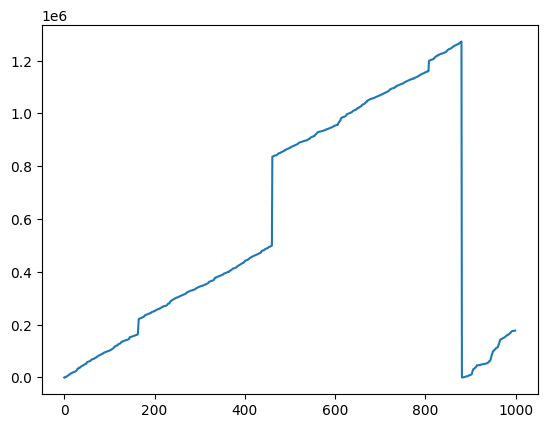

In [24]:
tdf['elapsed_time'].plot()
# tdf['elapsed_time_diff'].plot()


In [13]:
target = pd.read_csv('../data/raw/input/train_labels.csv')
target['session'] = target.session_id.apply(lambda x: int(x.split('_')[0]))
target['qid'] = target.session_id.apply(lambda x: int(x.split('_')[1][1:]))
target.head()

,session_id,correct,session,qid
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1


In [15]:
# 10개의 data, target 묶음 만들기
import random
id_pick = random.sample(train.session_id.unique().tolist(), 10)
print(id_pick)

limits = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}

data_list = []
target_list = []
for tid in id_pick:
    for level_group in limits.keys():
        data_list.append(train.loc[(train.session_id == tid) & (train.level_group == level_group)])
        target_list.append(target.loc[(target.session == tid) & (target.qid.isin(list(range(*limits[level_group]))))])
        # display(data_list[-1])
        # display(target_list[-1])
iter_test = zip(data_list, target_list)

[22010314404562760, 22000510333989150, 21040313280165890, 21010619322383596, 21020214380873504, 21020509010622184, 22000414470037760, 21010411213380572, 22080308453194030, 22030517024952412]


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
21843446,22010314404562760,0,0,cutscene_click,basic,0,NaN,-388.228693,91.634466,399.0,239.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
21843447,22010314404562760,1,4178,person_click,basic,0,NaN,-183.821914,170.956500,600.0,161.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
21843448,22010314404562760,2,6439,person_click,basic,0,NaN,-357.720219,81.464975,429.0,249.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
21843449,22010314404562760,3,8270,person_click,basic,0,NaN,-357.720219,81.464975,429.0,249.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
21843450,22010314404562760,4,10302,person_click,basic,0,NaN,-357.720219,81.464975,429.0,249.0,NaN,Ugh. Meetings are so boring.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21843613,22010314404562760,167,331998,navigate_click,undefined,4,NaN,-891.471150,-77.796610,3.0,401.0,NaN,None,toentry,tunic.kohlcenter.halloffame,None,0,0,1,0-4
21843614,22010314404562760,168,332629,map_hover,basic,4,NaN,NaN,NaN,NaN,NaN,233.0,None,toentry,tunic.kohlcenter.halloffame,None,0,0,1,0-4
21843615,22010314404562760,169,333912,map_click,undefined,4,NaN,-554.354576,12.711864,438.0,312.0,NaN,None,tunic.capitol_0,tunic.kohlcenter.halloffame,None,0,0,1,0-4
21843616,22010314404562760,170,337957,navigate_click,undefined,4,NaN,285.412715,-5.748897,437.0,296.0,NaN,None,chap1_finale,tunic.capitol_0.hall,None,0,0,1,0-4


,session_id,correct,session,qid
19531,22010314404562760_q1,1,22010314404562760,1
43093,22010314404562760_q2,0,22010314404562760,2
66655,22010314404562760_q3,0,22010314404562760,3


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
21843618,22010314404562760,180,439012,navigate_click,undefined,5,NaN,445.131444,-316.084881,749.0,508.0,NaN,None,None,tunic.capitol_0.hall,None,0,0,1,5-12
21843619,22010314404562760,181,439662,navigate_click,undefined,5,NaN,580.294422,-356.466791,806.0,525.0,NaN,None,None,tunic.capitol_0.hall,None,0,0,1,5-12
21843620,22010314404562760,182,440194,navigate_click,undefined,5,NaN,655.338875,-364.868924,806.0,525.0,NaN,None,None,tunic.capitol_0.hall,None,0,0,1,5-12
21843621,22010314404562760,183,440644,navigate_click,undefined,5,NaN,723.332398,-367.745280,806.0,525.0,NaN,None,None,tunic.capitol_0.hall,None,0,0,1,5-12
21843622,22010314404562760,184,441261,navigate_click,undefined,5,NaN,812.552173,-435.546850,809.0,568.0,NaN,None,None,tunic.capitol_0.hall,None,0,0,1,5-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21844070,22010314404562760,632,1176703,navigate_click,undefined,12,NaN,847.637524,186.020722,840.0,207.0,NaN,None,tomap,tunic.historicalsociety.entry,None,0,0,1,5-12
21844071,22010314404562760,633,1177652,navigate_click,undefined,12,NaN,927.845440,106.202242,826.0,259.0,NaN,None,tomap,tunic.historicalsociety.entry,None,0,0,1,5-12
21844072,22010314404562760,634,1179436,map_click,undefined,12,NaN,488.416126,-18.073154,457.0,335.0,NaN,None,tunic.capitol_1,tunic.historicalsociety.entry,None,0,0,1,5-12
21844073,22010314404562760,635,1182696,navigate_click,undefined,12,NaN,245.351081,-21.157217,411.0,306.0,NaN,None,chap2_finale_c,tunic.capitol_1.hall,None,0,0,1,5-12


,session_id,correct,session,qid
90217,22010314404562760_q4,0,22010314404562760,4
113779,22010314404562760_q5,1,22010314404562760,5
137341,22010314404562760_q6,1,22010314404562760,6
160903,22010314404562760_q7,1,22010314404562760,7
184465,22010314404562760_q8,0,22010314404562760,8
208027,22010314404562760_q9,0,22010314404562760,9
231589,22010314404562760_q10,0,22010314404562760,10
255151,22010314404562760_q11,1,22010314404562760,11
278713,22010314404562760_q12,1,22010314404562760,12
302275,22010314404562760_q13,0,22010314404562760,13


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
21844075,22010314404562760,698,86302986,navigate_click,undefined,13,NaN,487.148927,-351.520423,768.0,533.0,NaN,None,None,tunic.capitol_1.hall,None,0,0,1,13-22
21844076,22010314404562760,699,86303669,navigate_click,undefined,13,NaN,532.443499,-355.732746,764.0,525.0,NaN,None,None,tunic.capitol_1.hall,None,0,0,1,13-22
21844077,22010314404562760,700,86304184,navigate_click,undefined,13,NaN,586.787580,-378.317589,752.0,534.0,NaN,None,None,tunic.capitol_1.hall,None,0,0,1,13-22
21844078,22010314404562760,701,86305301,navigate_click,undefined,13,NaN,758.883206,-195.164505,776.0,412.0,NaN,None,toentry,tunic.capitol_1.hall,None,0,0,1,13-22
21844079,22010314404562760,702,86306599,map_hover,basic,13,NaN,NaN,NaN,NaN,NaN,983.0,None,toentry,tunic.capitol_1.hall,None,0,0,1,13-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21844852,22010314404562760,1475,87331912,map_hover,basic,22,NaN,NaN,NaN,NaN,NaN,32.0,None,tunic.capitol_2,tunic.historicalsociety.entry,None,0,0,1,13-22
21844853,22010314404562760,1476,87332694,map_hover,basic,22,NaN,NaN,NaN,NaN,NaN,465.0,None,tunic.library,tunic.historicalsociety.entry,None,0,0,1,13-22
21844854,22010314404562760,1477,87333010,map_click,undefined,22,NaN,480.858815,23.352529,450.0,310.0,NaN,None,tunic.capitol_2,tunic.historicalsociety.entry,None,0,0,1,13-22
21844855,22010314404562760,1478,87334092,navigate_click,undefined,22,NaN,220.697768,0.414431,395.0,292.0,NaN,None,chap4_finale_c,tunic.capitol_2.hall,None,0,0,1,13-22


,session_id,correct,session,qid
325837,22010314404562760_q14,0,22010314404562760,14
349399,22010314404562760_q15,0,22010314404562760,15
372961,22010314404562760_q16,0,22010314404562760,16
396523,22010314404562760_q17,1,22010314404562760,17
420085,22010314404562760_q18,1,22010314404562760,18


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
21291624,22000510333989150,0,0,cutscene_click,basic,0,NaN,-435.991405,122.685314,358.0,212.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,0,0-4
21291625,22000510333989150,1,1133,person_click,basic,0,NaN,-416.991405,107.685314,377.0,227.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,0,0-4
21291626,22000510333989150,2,1732,person_click,basic,0,NaN,-411.991405,105.685314,382.0,229.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,0,0-4
21291627,22000510333989150,3,3290,person_click,basic,0,NaN,-402.991405,100.685314,391.0,234.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,0,0-4
21291628,22000510333989150,4,3030,person_click,basic,0,NaN,-402.991405,100.685314,391.0,234.0,NaN,Ugh. Meetings are so boring.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,0,0-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21291741,22000510333989150,117,194142,map_hover,basic,4,NaN,NaN,NaN,NaN,NaN,17.0,None,tunic.kohlcenter,tunic.kohlcenter.halloffame,None,0,0,0,0-4
21291742,22000510333989150,118,196041,map_click,undefined,4,NaN,-535.817668,-9.000000,467.0,339.0,NaN,None,tunic.capitol_0,tunic.kohlcenter.halloffame,None,0,0,0,0-4
21291743,22000510333989150,119,198372,navigate_click,undefined,4,NaN,31.766079,53.367693,277.0,262.0,NaN,None,chap1_finale,tunic.capitol_0.hall,None,0,0,0,0-4
21291744,22000510333989150,120,201020,navigate_click,undefined,4,NaN,-37.597866,-6.537905,386.0,312.0,NaN,None,chap1_finale,tunic.capitol_0.hall,None,0,0,0,0-4


,session_id,correct,session,qid
19040,22000510333989150_q1,0,22000510333989150,1
42602,22000510333989150_q2,1,22000510333989150,2
66164,22000510333989150_q3,1,22000510333989150,3


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
21291746,22000510333989150,129,303086,navigate_click,undefined,5,NaN,494.078542,-377.281594,794.0,557.0,NaN,None,None,tunic.capitol_0.hall,None,0,0,0,5-12
21291747,22000510333989150,130,305583,navigate_click,undefined,5,NaN,803.176274,-77.284874,831.0,341.0,NaN,None,toentry,tunic.capitol_0.hall,None,0,0,0,5-12
21291748,22000510333989150,131,308381,map_click,undefined,5,NaN,431.672841,171.827355,541.0,195.0,NaN,None,tunic.historicalsociety,tunic.capitol_0.hall,None,0,0,0,5-12
21291749,22000510333989150,132,310213,navigate_click,undefined,5,NaN,703.563093,74.254306,591.0,282.0,NaN,None,tobasement,tunic.historicalsociety.entry,None,0,0,0,5-12
21291750,22000510333989150,133,312328,navigate_click,undefined,5,NaN,138.731417,-74.264333,626.0,374.0,NaN,None,tocloset_dirty,tunic.historicalsociety.basement,None,0,0,0,5-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21292012,22000510333989150,395,766540,map_hover,basic,12,NaN,NaN,NaN,NaN,NaN,527.0,None,tunic.drycleaner,tunic.historicalsociety.entry,None,0,0,0,5-12
21292013,22000510333989150,396,767383,map_hover,basic,12,NaN,NaN,NaN,NaN,NaN,367.0,None,tunic.kohlcenter,tunic.historicalsociety.entry,None,0,0,0,5-12
21292014,22000510333989150,397,768265,map_click,undefined,12,NaN,431.310972,28.685967,424.0,312.0,NaN,None,tunic.capitol_1,tunic.historicalsociety.entry,None,0,0,0,5-12
21292015,22000510333989150,398,769263,navigate_click,undefined,12,NaN,260.553957,-13.298974,428.0,306.0,NaN,None,chap2_finale_c,tunic.capitol_1.hall,None,0,0,0,5-12


,session_id,correct,session,qid
89726,22000510333989150_q4,1,22000510333989150,4
113288,22000510333989150_q5,1,22000510333989150,5
136850,22000510333989150_q6,1,22000510333989150,6
160412,22000510333989150_q7,1,22000510333989150,7
183974,22000510333989150_q8,0,22000510333989150,8
207536,22000510333989150_q9,1,22000510333989150,9
231098,22000510333989150_q10,1,22000510333989150,10
254660,22000510333989150_q11,0,22000510333989150,11
278222,22000510333989150_q12,1,22000510333989150,12
301784,22000510333989150_q13,1,22000510333989150,13


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
21292017,22000510333989150,436,1299561,navigate_click,undefined,13,NaN,481.062640,-386.317547,777.0,565.0,NaN,None,None,tunic.capitol_1.hall,None,0,0,0,13-22
21292018,22000510333989150,437,1302026,navigate_click,undefined,13,NaN,753.775145,-180.227997,800.0,409.0,NaN,None,toentry,tunic.capitol_1.hall,None,0,0,0,13-22
21292019,22000510333989150,438,1304612,map_click,undefined,13,NaN,444.958322,215.632841,550.0,166.0,NaN,None,tunic.historicalsociety,tunic.capitol_1.hall,None,0,0,0,13-22
21292020,22000510333989150,439,1305805,navigate_click,undefined,13,NaN,597.719457,175.212852,526.0,220.0,NaN,None,tobasement,tunic.historicalsociety.entry,None,0,0,0,13-22
21292021,22000510333989150,440,1308006,cutscene_click,basic,13,NaN,-23.310191,-56.449742,530.0,370.0,NaN,Jo!,ch3start,tunic.historicalsociety.basement,tunic.historicalsociety.basement.ch3start,0,0,0,13-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21292477,22000510333989150,896,2483803,map_hover,basic,22,NaN,NaN,NaN,NaN,NaN,1597.0,None,tomap,tunic.historicalsociety.entry,None,0,0,0,13-22
21292478,22000510333989150,897,2484971,map_hover,basic,22,NaN,NaN,NaN,NaN,NaN,370.0,None,tunic.library,tunic.historicalsociety.entry,None,0,0,0,13-22
21292479,22000510333989150,898,2485800,map_click,undefined,22,NaN,508.654270,-13.656883,472.0,338.0,NaN,None,tunic.capitol_2,tunic.historicalsociety.entry,None,0,0,0,13-22
21292480,22000510333989150,899,2486850,navigate_click,undefined,22,NaN,287.826685,-22.389883,446.0,312.0,NaN,None,chap4_finale_c,tunic.capitol_2.hall,None,0,0,0,13-22


,session_id,correct,session,qid
325346,22000510333989150_q14,1,22000510333989150,14
348908,22000510333989150_q15,0,22000510333989150,15
372470,22000510333989150_q16,0,22000510333989150,16
396032,22000510333989150_q17,1,22000510333989150,17
419594,22000510333989150_q18,1,22000510333989150,18


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
13611065,21040313280165890,0,0,cutscene_click,basic,0,NaN,-438.991405,65.685314,355.0,269.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
13611066,21040313280165890,1,2382,person_click,basic,0,NaN,-413.991405,107.685314,380.0,227.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
13611067,21040313280165890,2,4042,person_click,basic,0,NaN,-120.991405,-153.314686,673.0,488.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
13611068,21040313280165890,3,5377,person_click,basic,0,NaN,-427.991405,100.685314,366.0,234.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
13611069,21040313280165890,4,6930,person_click,basic,0,NaN,37.008595,-153.314686,831.0,488.0,NaN,Meetings are BORING!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13612234,21040313280165890,1240,4805614,navigate_click,undefined,4,NaN,-870.756783,20.000000,11.0,310.0,NaN,None,toentry,tunic.kohlcenter.halloffame,None,0,0,1,0-4
13612235,21040313280165890,1241,4806431,map_hover,basic,4,NaN,NaN,NaN,NaN,NaN,684.0,None,toentry,tunic.kohlcenter.halloffame,None,0,0,1,0-4
13612236,21040313280165890,1242,4807214,map_click,undefined,4,NaN,-543.518570,18.000000,453.0,312.0,NaN,None,tunic.capitol_0,tunic.kohlcenter.halloffame,None,0,0,1,0-4
13612237,21040313280165890,1243,4808609,navigate_click,undefined,4,NaN,-57.627861,15.488905,218.0,287.0,NaN,None,chap1_finale,tunic.capitol_0.hall,None,0,0,1,0-4


,session_id,correct,session,qid
12091,21040313280165890_q1,0,21040313280165890,1
35653,21040313280165890_q2,1,21040313280165890,2
59215,21040313280165890_q3,1,21040313280165890,3


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
13611236,21040313280165890,180,388109,navigate_click,undefined,5,NaN,536.502784,-296.978564,822.0,504.0,NaN,None,None,tunic.capitol_0.hall,None,0,0,1,5-12
13611237,21040313280165890,181,388552,navigate_click,undefined,5,NaN,561.383604,-305.622572,822.0,504.0,NaN,None,None,tunic.capitol_0.hall,None,0,0,1,5-12
13611238,21040313280165890,182,389051,navigate_click,undefined,5,NaN,624.344400,-315.203670,822.0,504.0,NaN,None,None,tunic.capitol_0.hall,None,0,0,1,5-12
13611239,21040313280165890,183,389652,navigate_click,undefined,5,NaN,714.438684,-320.432296,822.0,504.0,NaN,None,None,tunic.capitol_0.hall,None,0,0,1,5-12
13611240,21040313280165890,184,390269,navigate_click,undefined,5,NaN,827.903195,-71.220971,840.0,338.0,NaN,None,toentry,tunic.capitol_0.hall,None,0,0,1,5-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13612546,21040313280165890,1560,5153266,map_hover,basic,12,NaN,NaN,NaN,NaN,NaN,1368.0,None,tomap,tunic.historicalsociety.entry,None,0,0,1,5-12
13612547,21040313280165890,1561,5153665,map_hover,basic,12,NaN,NaN,NaN,NaN,NaN,64.0,None,tunic.drycleaner,tunic.historicalsociety.entry,None,0,0,1,5-12
13612548,21040313280165890,1562,5154616,map_click,undefined,12,NaN,488.434695,12.188363,461.0,322.0,NaN,None,tunic.capitol_1,tunic.historicalsociety.entry,None,0,0,1,5-12
13612549,21040313280165890,1563,5155424,navigate_click,undefined,12,NaN,236.311533,-73.905034,412.0,346.0,NaN,None,chap2_finale_c,tunic.capitol_1.hall,None,0,0,1,5-12


,session_id,correct,session,qid
82777,21040313280165890_q4,1,21040313280165890,4
106339,21040313280165890_q5,0,21040313280165890,5
129901,21040313280165890_q6,1,21040313280165890,6
153463,21040313280165890_q7,1,21040313280165890,7
177025,21040313280165890_q8,1,21040313280165890,8
200587,21040313280165890_q9,1,21040313280165890,9
224149,21040313280165890_q10,0,21040313280165890,10
247711,21040313280165890_q11,0,21040313280165890,11
271273,21040313280165890_q12,0,21040313280165890,12
294835,21040313280165890_q13,0,21040313280165890,13


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
13611609,21040313280165890,592,1082470,navigate_click,undefined,13,NaN,226.517186,50.046089,609.0,277.0,NaN,None,boss,tunic.capitol_1.hall,None,0,0,1,13-22
13611610,21040313280165890,593,1084322,person_click,basic,13,NaN,243.253956,-14.021933,628.0,315.0,NaN,Head back to the museum. Your gramps is waitin...,boss,tunic.capitol_1.hall,tunic.capitol_1.hall.boss.writeitup,0,0,1,13-22
13611611,21040313280165890,594,1085564,navigate_click,undefined,13,NaN,464.201452,-236.895545,774.0,462.0,NaN,None,None,tunic.capitol_1.hall,None,0,0,1,13-22
13611612,21040313280165890,595,1085384,navigate_click,undefined,13,NaN,587.467609,-110.759535,832.0,375.0,NaN,None,None,tunic.capitol_1.hall,None,0,0,1,13-22
13611613,21040313280165890,596,1086403,navigate_click,undefined,13,NaN,802.002903,-132.115166,878.0,399.0,NaN,None,toentry,tunic.capitol_1.hall,None,0,0,1,13-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13613006,21040313280165890,2057,6037045,navigate_click,undefined,22,NaN,507.766554,-107.504441,837.0,432.0,NaN,None,tomap,tunic.flaghouse.entry,None,0,0,1,13-22
13613007,21040313280165890,2058,6038334,map_hover,basic,22,NaN,NaN,NaN,NaN,NaN,632.0,None,tomap,tunic.flaghouse.entry,None,0,0,1,13-22
13613008,21040313280165890,2059,6039664,map_click,undefined,22,NaN,188.163340,39.402082,455.0,284.0,NaN,None,tunic.capitol_2,tunic.flaghouse.entry,None,0,0,1,13-22
13613009,21040313280165890,2060,6039527,navigate_click,undefined,22,NaN,275.705473,20.034360,438.0,284.0,NaN,None,chap4_finale_c,tunic.capitol_2.hall,None,0,0,1,13-22


,session_id,correct,session,qid
318397,21040313280165890_q14,0,21040313280165890,14
341959,21040313280165890_q15,1,21040313280165890,15
365521,21040313280165890_q16,0,21040313280165890,16
389083,21040313280165890_q17,1,21040313280165890,17
412645,21040313280165890_q18,1,21040313280165890,18


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
7881974,21010619322383596,0,0,cutscene_click,basic,0,NaN,-490.991405,74.685314,303.0,260.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
7881975,21010619322383596,1,7113,person_click,basic,0,NaN,-449.991405,46.685314,344.0,288.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
7881976,21010619322383596,2,13714,person_click,basic,0,NaN,-473.991405,-5.314686,320.0,340.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
7881977,21010619322383596,3,15612,person_click,basic,0,NaN,-501.991405,-93.314686,292.0,428.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
7881978,21010619322383596,4,17078,person_click,basic,0,NaN,-501.991405,-93.314686,292.0,428.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7882176,21010619322383596,202,364733,navigate_click,undefined,4,NaN,-932.060307,2.000000,31.0,328.0,NaN,None,toentry,tunic.kohlcenter.halloffame,None,0,0,1,0-4
7882177,21010619322383596,203,365881,map_hover,basic,4,NaN,NaN,NaN,NaN,NaN,100.0,None,tunic.capitol_0,tunic.kohlcenter.halloffame,None,0,0,1,0-4
7882178,21010619322383596,204,366263,map_click,undefined,4,NaN,-496.785125,21.000000,504.0,309.0,NaN,None,tunic.capitol_0,tunic.kohlcenter.halloffame,None,0,0,1,0-4
7882179,21010619322383596,205,368596,navigate_click,undefined,4,NaN,207.523654,-13.298974,393.0,306.0,NaN,None,chap1_finale,tunic.capitol_0.hall,None,0,0,1,0-4


,session_id,correct,session,qid
7006,21010619322383596_q1,1,21010619322383596,1
30568,21010619322383596_q2,1,21010619322383596,2
54130,21010619322383596_q3,1,21010619322383596,3


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
7882181,21010619322383596,214,452413,navigate_click,undefined,5,NaN,298.623996,112.112345,665.0,234.0,NaN,None,boss,tunic.capitol_0.hall,None,0,0,1,5-12
7882182,21010619322383596,215,453475,person_click,basic,5,NaN,284.977218,-147.978396,657.0,406.0,NaN,"What are you still doing here, Jolie?",boss,tunic.capitol_0.hall,tunic.capitol_0.hall.boss.talktogramps,0,0,1,5-12
7882183,21010619322383596,216,454292,person_click,basic,5,NaN,284.773800,-147.909684,657.0,406.0,NaN,Go find your grampa and get to work!,boss,tunic.capitol_0.hall,tunic.capitol_0.hall.boss.talktogramps,0,0,1,5-12
7882184,21010619322383596,217,454791,navigate_click,undefined,5,NaN,393.830105,-285.776783,729.0,497.0,NaN,None,None,tunic.capitol_0.hall,None,0,0,1,5-12
7882185,21010619322383596,218,456558,navigate_click,undefined,5,NaN,587.003224,-299.199767,729.0,492.0,NaN,None,None,tunic.capitol_0.hall,None,0,0,1,5-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7882505,21010619322383596,538,888988,navigate_click,undefined,12,NaN,978.193542,16.542431,837.0,307.0,NaN,None,tomap,tunic.historicalsociety.entry,None,0,0,1,5-12
7882506,21010619322383596,539,889772,map_hover,basic,12,NaN,NaN,NaN,NaN,NaN,434.0,None,tomap,tunic.historicalsociety.entry,None,0,0,1,5-12
7882507,21010619322383596,540,891155,map_click,undefined,12,NaN,451.700431,13.449595,438.0,321.0,NaN,None,tunic.capitol_1,tunic.historicalsociety.entry,None,0,0,1,5-12
7882508,21010619322383596,541,892039,navigate_click,undefined,12,NaN,252.978200,-23.905034,423.0,313.0,NaN,None,chap2_finale_c,tunic.capitol_1.hall,None,0,0,1,5-12


,session_id,correct,session,qid
77692,21010619322383596_q4,1,21010619322383596,4
101254,21010619322383596_q5,1,21010619322383596,5
124816,21010619322383596_q6,1,21010619322383596,6
148378,21010619322383596_q7,1,21010619322383596,7
171940,21010619322383596_q8,1,21010619322383596,8
195502,21010619322383596_q9,1,21010619322383596,9
219064,21010619322383596_q10,0,21010619322383596,10
242626,21010619322383596_q11,1,21010619322383596,11
266188,21010619322383596_q12,1,21010619322383596,12
289750,21010619322383596_q13,1,21010619322383596,13


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
7882510,21010619322383596,577,1898425,navigate_click,undefined,13,NaN,256.820216,39.440028,629.0,284.0,NaN,None,boss,tunic.capitol_1.hall,None,0,0,1,13-22
7882511,21010619322383596,578,1899808,person_click,basic,13,NaN,84.783950,12.079007,523.0,298.0,NaN,Head back to the museum. Your gramps is waitin...,boss,tunic.capitol_1.hall,tunic.capitol_1.hall.boss.writeitup,0,0,1,13-22
7882512,21010619322383596,579,1918224,navigate_click,undefined,13,NaN,518.550354,-208.216361,810.0,443.0,NaN,None,None,tunic.capitol_1.hall,None,0,0,1,13-22
7882513,21010619322383596,580,1918740,navigate_click,undefined,13,NaN,557.949826,-223.041945,815.0,451.0,NaN,None,None,tunic.capitol_1.hall,None,0,0,1,13-22
7882514,21010619322383596,581,1919623,navigate_click,undefined,13,NaN,-435.293199,-111.579629,78.0,375.0,NaN,None,None,tunic.capitol_1.hall,None,0,0,1,13-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7883033,21010619322383596,1100,2591477,map_hover,basic,22,NaN,NaN,NaN,NaN,NaN,934.0,None,tomap,tunic.historicalsociety.entry,None,0,0,1,13-22
7883034,21010619322383596,1101,2591828,map_hover,basic,22,NaN,NaN,NaN,NaN,NaN,85.0,None,tunic.drycleaner,tunic.historicalsociety.entry,None,0,0,1,13-22
7883035,21010619322383596,1102,2592694,map_click,undefined,22,NaN,518.267595,18.340641,478.0,318.0,NaN,None,tunic.capitol_2,tunic.historicalsociety.entry,None,0,0,1,13-22
7883036,21010619322383596,1103,2594577,navigate_click,undefined,22,NaN,251.463048,-19.359580,422.0,310.0,NaN,None,chap4_finale_c,tunic.capitol_2.hall,None,0,0,1,13-22


,session_id,correct,session,qid
313312,21010619322383596_q14,1,21010619322383596,14
336874,21010619322383596_q15,1,21010619322383596,15
360436,21010619322383596_q16,1,21010619322383596,16
383998,21010619322383596_q17,1,21010619322383596,17
407560,21010619322383596_q18,1,21010619322383596,18


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
8820443,21020214380873504,0,0,cutscene_click,basic,0,NaN,-197.991405,34.685314,596.0,300.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
8820444,21020214380873504,1,2168,person_click,basic,0,NaN,-195.991405,67.685314,598.0,267.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
8820445,21020214380873504,2,4034,person_click,basic,0,NaN,-187.991405,54.685314,606.0,280.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
8820446,21020214380873504,3,5752,person_click,basic,0,NaN,-188.991405,50.685314,605.0,284.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
8820447,21020214380873504,4,16855,person_click,basic,0,NaN,-147.991405,-125.314686,646.0,460.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8820702,21020214380873504,259,414168,map_hover,basic,4,NaN,NaN,NaN,NaN,NaN,65.0,None,tunic.capitol_0,tunic.kohlcenter.halloffame,None,0,0,1,0-4
8820703,21020214380873504,260,414652,map_click,undefined,4,NaN,-523.329415,2.000000,478.0,328.0,NaN,None,tunic.capitol_0,tunic.kohlcenter.halloffame,None,0,0,1,0-4
8820704,21020214380873504,261,416968,navigate_click,undefined,4,NaN,256.008503,62.458602,425.0,256.0,NaN,None,chap1_finale,tunic.capitol_0.hall,None,0,0,1,0-4
8820705,21020214380873504,262,418735,navigate_click,undefined,4,NaN,219.636447,49.155561,521.0,275.0,NaN,None,chap1_finale,tunic.capitol_0.hall,None,0,0,1,0-4


,session_id,correct,session,qid
7842,21020214380873504_q1,1,21020214380873504,1
31404,21020214380873504_q2,1,21020214380873504,2
54966,21020214380873504_q3,1,21020214380873504,3


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
8820707,21020214380873504,271,581683,navigate_click,undefined,5,NaN,250.139148,-190.917958,633.0,434.0,NaN,None,None,tunic.capitol_0.hall,None,0,0,1,5-12
8820708,21020214380873504,272,582129,navigate_click,undefined,5,NaN,275.019967,-193.601289,633.0,434.0,NaN,None,None,tunic.capitol_0.hall,None,0,0,1,5-12
8820709,21020214380873504,273,582345,navigate_click,undefined,5,NaN,299.544972,-194.559485,633.0,434.0,NaN,None,None,tunic.capitol_0.hall,None,0,0,1,5-12
8820710,21020214380873504,274,582582,navigate_click,undefined,5,NaN,344.474098,-207.434662,642.0,442.0,NaN,None,None,tunic.capitol_0.hall,None,0,0,1,5-12
8820711,21020214380873504,275,582846,navigate_click,undefined,5,NaN,476.067186,-260.342058,703.0,476.0,NaN,None,None,tunic.capitol_0.hall,None,0,0,1,5-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8821267,21020214380873504,831,1496138,map_click,undefined,12,NaN,419.017639,2.583291,421.0,328.0,NaN,None,tunic.capitol_1,tunic.historicalsociety.entry,None,0,0,1,5-12
8821268,21020214380873504,832,1498238,navigate_click,undefined,12,NaN,221.160018,-63.298974,402.0,339.0,NaN,None,chap2_finale_c,tunic.capitol_1.hall,None,0,0,1,5-12
8821269,21020214380873504,833,1498924,navigate_click,undefined,12,NaN,285.848915,87.971447,468.0,247.0,NaN,None,chap2_finale_c,tunic.capitol_1.hall,None,0,0,1,5-12
8821270,21020214380873504,834,1499823,navigate_click,undefined,12,NaN,333.818074,162.228930,577.0,202.0,NaN,None,chap2_finale_c,tunic.capitol_1.hall,None,0,0,1,5-12


,session_id,correct,session,qid
78528,21020214380873504_q4,1,21020214380873504,4
102090,21020214380873504_q5,1,21020214380873504,5
125652,21020214380873504_q6,0,21020214380873504,6
149214,21020214380873504_q7,1,21020214380873504,7
172776,21020214380873504_q8,0,21020214380873504,8
196338,21020214380873504_q9,1,21020214380873504,9
219900,21020214380873504_q10,1,21020214380873504,10
243462,21020214380873504_q11,0,21020214380873504,11
267024,21020214380873504_q12,1,21020214380873504,12
290586,21020214380873504_q13,1,21020214380873504,13


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
8821272,21020214380873504,871,1824012,navigate_click,undefined,13,NaN,144.699004,-283.287244,555.0,497.0,NaN,None,None,tunic.capitol_1.hall,None,0,0,1,13-22
8821273,21020214380873504,872,1825044,navigate_click,undefined,13,NaN,252.151188,-294.696129,577.0,492.0,NaN,None,None,tunic.capitol_1.hall,None,0,0,1,13-22
8821274,21020214380873504,873,1825582,navigate_click,undefined,13,NaN,294.473544,-299.086658,577.0,492.0,NaN,None,None,tunic.capitol_1.hall,None,0,0,1,13-22
8821275,21020214380873504,874,1826061,navigate_click,undefined,13,NaN,430.846340,-275.308208,646.0,475.0,NaN,None,None,tunic.capitol_1.hall,None,0,0,1,13-22
8821276,21020214380873504,875,1827075,navigate_click,undefined,13,NaN,492.830211,-309.123246,668.0,498.0,NaN,None,None,tunic.capitol_1.hall,None,0,0,1,13-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8821953,21020214380873504,1552,5892608,navigate_click,undefined,22,NaN,232.341799,5.899594,444.0,301.0,NaN,None,chap4_finale_c,tunic.capitol_2.hall,None,0,0,1,13-22
8821954,21020214380873504,1553,5893507,navigate_click,undefined,22,NaN,339.017430,-22.413228,598.0,322.0,NaN,None,None,tunic.capitol_2.hall,None,0,0,1,13-22
8821955,21020214380873504,1554,5894240,navigate_click,undefined,22,NaN,294.564725,-12.507613,575.0,321.0,NaN,None,chap4_finale_c,tunic.capitol_2.hall,None,0,0,1,13-22
8821956,21020214380873504,1555,5894990,navigate_click,undefined,22,NaN,249.098266,-32.789267,560.0,331.0,NaN,None,chap4_finale_c,tunic.capitol_2.hall,None,0,0,1,13-22


,session_id,correct,session,qid
314148,21020214380873504_q14,1,21020214380873504,14
337710,21020214380873504_q15,1,21020214380873504,15
361272,21020214380873504_q16,1,21020214380873504,16
384834,21020214380873504_q17,0,21020214380873504,17
408396,21020214380873504_q18,1,21020214380873504,18


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
9842891,21020509010622184,0,0,cutscene_click,basic,0,NaN,-400.991405,-171.314686,393.0,506.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
9842892,21020509010622184,1,1046,person_click,basic,0,NaN,-266.991405,8.685314,527.0,326.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
9842893,21020509010622184,2,2045,person_click,basic,0,NaN,-267.991405,4.685314,526.0,330.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
9842894,21020509010622184,3,3112,person_click,basic,0,NaN,-267.991405,7.685314,526.0,327.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
9842895,21020509010622184,4,4011,person_click,basic,0,NaN,-267.991405,7.685314,526.0,327.0,NaN,Meetings are BORING!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9843024,21020509010622184,133,494792,navigate_click,undefined,4,NaN,-923.970994,53.000000,32.0,277.0,NaN,None,toentry,tunic.kohlcenter.halloffame,None,0,0,1,0-4
9843025,21020509010622184,134,496111,map_hover,basic,4,NaN,NaN,NaN,NaN,NaN,184.0,None,tunic.capitol_0,tunic.kohlcenter.halloffame,None,0,0,1,0-4
9843026,21020509010622184,135,496733,map_click,undefined,4,NaN,-535.313593,11.000000,466.0,319.0,NaN,None,tunic.capitol_0,tunic.kohlcenter.halloffame,None,0,0,1,0-4
9843027,21020509010622184,136,498126,navigate_click,undefined,4,NaN,234.796382,-52.692913,411.0,332.0,NaN,None,chap1_finale,tunic.capitol_0.hall,None,0,0,1,0-4


,session_id,correct,session,qid
8758,21020509010622184_q1,1,21020509010622184,1
32320,21020509010622184_q2,1,21020509010622184,2
55882,21020509010622184_q3,1,21020509010622184,3


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
9843029,21020509010622184,145,559177,navigate_click,undefined,5,NaN,533.472481,-393.948261,820.0,568.0,NaN,None,None,tunic.capitol_0.hall,None,0,0,1,5-12
9843030,21020509010622184,146,562226,navigate_click,undefined,5,NaN,826.910229,-151.290907,846.0,390.0,NaN,None,toentry,tunic.capitol_0.hall,None,0,0,1,5-12
9843031,21020509010622184,147,562281,map_hover,basic,5,NaN,NaN,NaN,NaN,NaN,333.0,None,toentry,tunic.capitol_0.hall,None,0,0,1,5-12
9843032,21020509010622184,148,562901,map_hover,basic,5,NaN,NaN,NaN,NaN,NaN,23.0,None,tunic.historicalsociety,tunic.capitol_0.hall,None,0,0,1,5-12
9843033,21020509010622184,149,563527,map_click,undefined,5,NaN,456.249411,193.840568,558.0,180.0,NaN,None,tunic.historicalsociety,tunic.capitol_0.hall,None,0,0,1,5-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9843295,21020509010622184,411,1000242,map_click,undefined,12,NaN,473.826964,41.692575,452.0,304.0,NaN,None,tunic.capitol_1,tunic.historicalsociety.entry,None,0,0,1,5-12
9843296,21020509010622184,412,1001075,navigate_click,undefined,12,NaN,296.917594,-10.268671,452.0,304.0,NaN,None,chap2_finale_c,tunic.capitol_1.hall,None,0,0,1,5-12
9843297,21020509010622184,413,1002743,navigate_click,undefined,12,NaN,178.209781,-13.323312,483.0,318.0,NaN,None,None,tunic.capitol_1.hall,None,0,0,1,5-12
9843298,21020509010622184,414,1003645,navigate_click,undefined,12,NaN,243.643929,-27.419256,543.0,332.0,NaN,None,chap2_finale_c,tunic.capitol_1.hall,None,0,0,1,5-12


,session_id,correct,session,qid
79444,21020509010622184_q4,1,21020509010622184,4
103006,21020509010622184_q5,1,21020509010622184,5
126568,21020509010622184_q6,1,21020509010622184,6
150130,21020509010622184_q7,1,21020509010622184,7
173692,21020509010622184_q8,1,21020509010622184,8
197254,21020509010622184_q9,1,21020509010622184,9
220816,21020509010622184_q10,1,21020509010622184,10
244378,21020509010622184_q11,1,21020509010622184,11
267940,21020509010622184_q12,1,21020509010622184,12
291502,21020509010622184_q13,1,21020509010622184,13


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
9843300,21020509010622184,454,1191500,navigate_click,undefined,13,NaN,271.971731,-2.984214,639.0,312.0,NaN,None,boss,tunic.capitol_1.hall,None,0,0,1,13-22
9843301,21020509010622184,455,1193465,person_click,basic,13,NaN,387.128202,-286.785233,723.0,495.0,NaN,Head back to the museum. Your gramps is waitin...,boss,tunic.capitol_1.hall,tunic.capitol_1.hall.boss.writeitup,0,0,1,13-22
9843302,21020509010622184,456,1194197,navigate_click,undefined,13,NaN,486.835850,-343.007511,789.0,532.0,NaN,None,None,tunic.capitol_1.hall,None,0,0,1,13-22
9843303,21020509010622184,457,1194780,navigate_click,undefined,13,NaN,606.403429,-462.509306,842.0,603.0,NaN,None,None,tunic.capitol_1.hall,None,0,0,1,13-22
9843304,21020509010622184,458,1196480,navigate_click,undefined,13,NaN,828.159059,-31.729460,837.0,311.0,NaN,None,toentry,tunic.capitol_1.hall,None,0,0,1,13-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9843724,21020509010622184,878,1841003,map_hover,basic,22,NaN,NaN,NaN,NaN,NaN,33.0,None,tunic.capitol_2,tunic.historicalsociety.entry,None,0,0,1,13-22
9843725,21020509010622184,879,1841235,map_hover,basic,22,NaN,NaN,NaN,NaN,NaN,183.0,None,tunic.library,tunic.historicalsociety.entry,None,0,0,1,13-22
9843726,21020509010622184,880,1841670,map_click,undefined,22,NaN,473.722007,35.178429,452.0,308.0,NaN,None,tunic.capitol_2,tunic.historicalsociety.entry,None,0,0,1,13-22
9843727,21020509010622184,881,1843653,navigate_click,undefined,22,NaN,254.493351,9.428299,424.0,291.0,NaN,None,chap4_finale_c,tunic.capitol_2.hall,None,0,0,1,13-22


,session_id,correct,session,qid
315064,21020509010622184_q14,1,21020509010622184,14
338626,21020509010622184_q15,1,21020509010622184,15
362188,21020509010622184_q16,1,21020509010622184,16
385750,21020509010622184_q17,1,21020509010622184,17
409312,21020509010622184_q18,1,21020509010622184,18


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
21197476,22000414470037760,0,0,cutscene_click,basic,0,NaN,-443.991405,21.685314,350.0,313.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
21197477,22000414470037760,1,3850,person_click,basic,0,NaN,-600.991405,-26.314686,193.0,361.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
21197478,22000414470037760,2,5183,person_click,basic,0,NaN,-626.991405,4.685314,167.0,330.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
21197479,22000414470037760,3,6919,person_click,basic,0,NaN,-575.991405,-9.314686,218.0,344.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
21197480,22000414470037760,4,7536,person_click,basic,0,NaN,-575.991405,-9.314686,218.0,344.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21197669,22000414470037760,193,246815,navigate_click,undefined,4,NaN,-803.751630,-85.000000,90.0,415.0,NaN,None,None,tunic.kohlcenter.halloffame,None,0,0,1,0-4
21197670,22000414470037760,194,247450,navigate_click,undefined,4,NaN,-949.823067,-88.000000,5.0,418.0,NaN,None,toentry,tunic.kohlcenter.halloffame,None,0,0,1,0-4
21197671,22000414470037760,195,249437,map_click,undefined,4,NaN,-523.612777,21.000000,478.0,309.0,NaN,None,tunic.capitol_0,tunic.kohlcenter.halloffame,None,0,0,1,0-4
21197672,22000414470037760,196,252327,navigate_click,undefined,4,NaN,254.493351,-52.692913,424.0,332.0,NaN,None,chap1_finale,tunic.capitol_0.hall,None,0,0,1,0-4


,session_id,correct,session,qid
18957,22000414470037760_q1,0,22000414470037760,1
42519,22000414470037760_q2,1,22000414470037760,2
66081,22000414470037760_q3,1,22000414470037760,3


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
21197674,22000414470037760,208,384326,navigate_click,undefined,5,NaN,-531.679034,-337.887655,117.0,531.0,NaN,None,None,tunic.capitol_0.hall,None,0,0,1,5-12
21197675,22000414470037760,209,385095,navigate_click,undefined,5,NaN,-608.549465,-409.594217,106.0,567.0,NaN,None,None,tunic.capitol_0.hall,None,0,0,1,5-12
21197676,22000414470037760,210,385728,navigate_click,undefined,5,NaN,-632.007798,-456.328458,138.0,593.0,NaN,None,None,tunic.capitol_0.hall,None,0,0,1,5-12
21197677,22000414470037760,211,385912,navigate_click,undefined,5,NaN,-642.372548,-457.244939,138.0,593.0,NaN,None,None,tunic.capitol_0.hall,None,0,0,1,5-12
21197678,22000414470037760,212,387044,navigate_click,undefined,5,NaN,387.898473,-233.499804,833.0,444.0,NaN,None,None,tunic.capitol_0.hall,None,0,0,1,5-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21198126,22000414470037760,660,1003619,navigate_click,undefined,12,NaN,905.230826,25.157994,836.0,300.0,NaN,None,tomap,tunic.historicalsociety.entry,None,0,0,1,5-12
21198127,22000414470037760,661,1005917,map_click,undefined,12,NaN,449.106018,31.514319,442.0,309.0,NaN,None,tunic.capitol_1,tunic.historicalsociety.entry,None,0,0,1,5-12
21198128,22000414470037760,662,1006155,navigate_click,undefined,12,NaN,281.766079,-17.844428,442.0,309.0,NaN,None,chap2_finale_c,tunic.capitol_1.hall,None,0,0,1,5-12
21198129,22000414470037760,663,1007475,navigate_click,undefined,12,NaN,254.253557,15.861584,498.0,298.0,NaN,None,chap2_finale_c,tunic.capitol_1.hall,None,0,0,1,5-12


,session_id,correct,session,qid
89643,22000414470037760_q4,1,22000414470037760,4
113205,22000414470037760_q5,0,22000414470037760,5
136767,22000414470037760_q6,1,22000414470037760,6
160329,22000414470037760_q7,0,22000414470037760,7
183891,22000414470037760_q8,1,22000414470037760,8
207453,22000414470037760_q9,1,22000414470037760,9
231015,22000414470037760_q10,0,22000414470037760,10
254577,22000414470037760_q11,1,22000414470037760,11
278139,22000414470037760_q12,1,22000414470037760,12
301701,22000414470037760_q13,0,22000414470037760,13


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
21198131,22000414470037760,704,1427195,navigate_click,undefined,13,NaN,493.183852,-325.711487,785.0,525.0,NaN,None,None,tunic.capitol_1.hall,None,0,0,1,13-22
21198132,22000414470037760,705,1429050,navigate_click,undefined,13,NaN,809.379654,-150.202462,855.0,390.0,NaN,None,toentry,tunic.capitol_1.hall,None,0,0,1,13-22
21198133,22000414470037760,706,1429917,map_click,basic,13,NaN,882.104825,-132.540795,855.0,390.0,NaN,None,None,tunic.capitol_1.hall,None,0,0,1,13-22
21198134,22000414470037760,707,1431165,map_click,close,13,NaN,857.112050,362.159493,823.0,69.0,NaN,None,None,tunic.capitol_1.hall,None,0,0,1,13-22
21198135,22000414470037760,708,1432187,navigate_click,undefined,13,NaN,815.168300,-125.011100,794.0,391.0,NaN,None,toentry,tunic.capitol_1.hall,None,0,0,1,13-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21198646,22000414470037760,1219,2085835,map_hover,basic,22,NaN,NaN,NaN,NaN,NaN,101.0,None,tunic.drycleaner,tunic.historicalsociety.entry,None,0,0,1,13-22
21198647,22000414470037760,1220,2085886,map_hover,basic,22,NaN,NaN,NaN,NaN,NaN,33.0,None,tunic.capitol_2,tunic.historicalsociety.entry,None,0,0,1,13-22
21198648,22000414470037760,1221,2086643,map_click,undefined,22,NaN,482.747345,59.186305,459.0,293.0,NaN,None,tunic.capitol_2,tunic.historicalsociety.entry,None,0,0,1,13-22
21198649,22000414470037760,1222,2088847,navigate_click,undefined,22,NaN,252.978200,41.246481,423.0,270.0,NaN,None,chap4_finale_c,tunic.capitol_2.hall,None,0,0,1,13-22


,session_id,correct,session,qid
325263,22000414470037760_q14,1,22000414470037760,14
348825,22000414470037760_q15,0,22000414470037760,15
372387,22000414470037760_q16,1,22000414470037760,16
395949,22000414470037760_q17,1,22000414470037760,17
419511,22000414470037760_q18,1,22000414470037760,18


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
7184091,21010411213380572,0,0,cutscene_click,basic,0,NaN,-323.991405,79.685314,470.0,255.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
7184092,21010411213380572,1,1300,person_click,basic,0,NaN,-175.991405,155.685314,618.0,179.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
7184093,21010411213380572,2,2866,person_click,basic,0,NaN,-261.991405,8.685314,532.0,326.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
7184094,21010411213380572,3,4486,person_click,basic,0,NaN,-260.991405,8.685314,533.0,326.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
7184095,21010411213380572,4,5682,person_click,basic,0,NaN,-262.991405,8.685314,531.0,326.0,NaN,Ugh. Meetings are so boring.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7184352,21010411213380572,261,258057,map_click,undefined,4,NaN,-529.838784,40.000000,469.0,290.0,NaN,None,tunic.capitol_0,tunic.kohlcenter.halloffame,None,0,0,1,0-4
7184353,21010411213380572,262,261741,navigate_click,undefined,4,NaN,-66.718770,62.458602,212.0,256.0,NaN,None,chap1_finale,tunic.capitol_0.hall,None,0,0,1,0-4
7184354,21010411213380572,263,262575,navigate_click,undefined,4,NaN,-34.009840,86.300129,267.0,248.0,NaN,None,chap1_finale,tunic.capitol_0.hall,None,0,0,1,0-4
7184355,21010411213380572,264,263707,navigate_click,undefined,4,NaN,21.315294,146.381075,412.0,211.0,NaN,None,chap1_finale,tunic.capitol_0.hall,None,0,0,1,0-4


,session_id,correct,session,qid
6387,21010411213380572_q1,1,21010411213380572,1
29949,21010411213380572_q2,1,21010411213380572,2
53511,21010411213380572_q3,1,21010411213380572,3


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
7184357,21010411213380572,273,310100,navigate_click,undefined,5,NaN,322.866421,-246.978564,681.0,471.0,NaN,None,None,tunic.capitol_0.hall,None,0,0,1,5-12
7184358,21010411213380572,274,310763,navigate_click,undefined,5,NaN,426.817699,-309.549510,717.0,506.0,NaN,None,None,tunic.capitol_0.hall,None,0,0,1,5-12
7184359,21010411213380572,275,311496,navigate_click,undefined,5,NaN,552.372626,-375.199309,730.0,542.0,NaN,None,None,tunic.capitol_0.hall,None,0,0,1,5-12
7184360,21010411213380572,276,312198,navigate_click,undefined,5,NaN,692.205488,-377.234638,762.0,540.0,NaN,None,None,tunic.capitol_0.hall,None,0,0,1,5-12
7184361,21010411213380572,277,312829,navigate_click,undefined,5,NaN,815.106809,-393.764380,809.0,550.0,NaN,None,None,tunic.capitol_0.hall,None,0,0,1,5-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7184812,21010411213380572,728,738257,navigate_click,undefined,12,NaN,955.154617,77.841551,845.0,281.0,NaN,None,tomap,tunic.historicalsociety.entry,None,0,0,1,5-12
7184813,21010411213380572,729,739089,map_hover,basic,12,NaN,NaN,NaN,NaN,NaN,333.0,None,tomap,tunic.historicalsociety.entry,None,0,0,1,5-12
7184814,21010411213380572,730,739605,map_click,undefined,12,NaN,450.399097,22.062138,446.0,316.0,NaN,None,tunic.capitol_1,tunic.historicalsociety.entry,None,0,0,1,5-12
7184815,21010411213380572,731,740422,navigate_click,undefined,12,NaN,259.038806,-14.814125,427.0,307.0,NaN,None,chap2_finale_c,tunic.capitol_1.hall,None,0,0,1,5-12


,session_id,correct,session,qid
77073,21010411213380572_q4,1,21010411213380572,4
100635,21010411213380572_q5,0,21010411213380572,5
124197,21010411213380572_q6,0,21010411213380572,6
147759,21010411213380572_q7,1,21010411213380572,7
171321,21010411213380572_q8,0,21010411213380572,8
194883,21010411213380572_q9,1,21010411213380572,9
218445,21010411213380572_q10,0,21010411213380572,10
242007,21010411213380572_q11,1,21010411213380572,11
265569,21010411213380572_q12,1,21010411213380572,12
289131,21010411213380572_q13,0,21010411213380572,13


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
7184817,21010411213380572,781,912760,navigate_click,undefined,13,NaN,520.456580,-271.166032,803.0,489.0,NaN,None,None,tunic.capitol_1.hall,None,0,0,1,13-22
7184818,21010411213380572,782,913056,navigate_click,undefined,13,NaN,532.238199,-275.593303,803.0,489.0,NaN,None,None,tunic.capitol_1.hall,None,0,0,1,13-22
7184819,21010411213380572,783,916289,navigate_click,undefined,13,NaN,791.320710,-80.528545,805.0,348.0,NaN,None,toentry,tunic.capitol_1.hall,None,0,0,1,13-22
7184820,21010411213380572,784,917006,map_hover,basic,13,NaN,NaN,NaN,NaN,NaN,333.0,None,toentry,tunic.capitol_1.hall,None,0,0,1,13-22
7184821,21010411213380572,785,917823,map_hover,basic,13,NaN,NaN,NaN,NaN,NaN,266.0,None,tunic.drycleaner,tunic.capitol_1.hall,None,0,0,1,13-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7185344,21010411213380572,1308,3149898,map_hover,basic,22,NaN,NaN,NaN,NaN,NaN,263.0,None,tunic.historicalsociety,tunic.historicalsociety.entry,None,0,0,1,13-22
7185345,21010411213380572,1309,3150646,map_hover,basic,22,NaN,NaN,NaN,NaN,NaN,284.0,None,tunic.library,tunic.historicalsociety.entry,None,0,0,1,13-22
7185346,21010411213380572,1310,3150716,map_click,undefined,22,NaN,493.048026,43.166823,463.0,303.0,NaN,None,tunic.capitol_2,tunic.historicalsociety.entry,None,0,0,1,13-22
7185347,21010411213380572,1311,3152666,navigate_click,undefined,22,NaN,265.099412,23.064663,431.0,282.0,NaN,None,chap4_finale_c,tunic.capitol_2.hall,None,0,0,1,13-22


,session_id,correct,session,qid
312693,21010411213380572_q14,0,21010411213380572,14
336255,21010411213380572_q15,1,21010411213380572,15
359817,21010411213380572_q16,1,21010411213380572,16
383379,21010411213380572_q17,1,21010411213380572,17
406941,21010411213380572_q18,1,21010411213380572,18


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
25395805,22080308453194030,0,0,cutscene_click,basic,0,NaN,16.008595,-44.314686,810.0,379.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
25395806,22080308453194030,1,216,cutscene_click,basic,0,NaN,-741.991405,7.685314,52.0,327.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
25395807,22080308453194030,2,275,cutscene_click,basic,0,NaN,-741.991405,7.685314,52.0,327.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
25395808,22080308453194030,3,611,cutscene_click,basic,0,NaN,-744.991405,43.685314,49.0,291.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
25395809,22080308453194030,4,2695,cutscene_click,basic,0,NaN,-744.991405,-25.314686,49.0,360.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25395996,22080308453194030,191,93751,navigate_click,undefined,4,NaN,-74.660305,8.413804,202.0,285.0,NaN,None,chap1_finale,tunic.capitol_0.hall,None,0,0,1,0-4
25395997,22080308453194030,192,94027,navigate_click,undefined,4,NaN,-1.060795,-13.402046,254.0,301.0,NaN,None,chap1_finale,tunic.capitol_0.hall,None,0,0,1,0-4
25395998,22080308453194030,193,94216,navigate_click,undefined,4,NaN,-13.320559,-10.884339,253.0,303.0,NaN,None,chap1_finale,tunic.capitol_0.hall,None,0,0,1,0-4
25395999,22080308453194030,194,95317,navigate_click,undefined,4,NaN,-16.783355,-38.184620,262.0,325.0,NaN,None,chap1_finale,tunic.capitol_0.hall,None,0,0,1,0-4


,session_id,correct,session,qid
22741,22080308453194030_q1,1,22080308453194030,1
46303,22080308453194030_q2,1,22080308453194030,2
69865,22080308453194030_q3,1,22080308453194030,3


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
25396001,22080308453194030,205,144697,navigate_click,undefined,5,NaN,488.017936,-245.463413,790.0,470.0,NaN,None,None,tunic.capitol_0.hall,None,0,0,1,5-12
25396002,22080308453194030,206,144616,navigate_click,undefined,5,NaN,495.559251,-239.588354,792.0,465.0,NaN,None,None,tunic.capitol_0.hall,None,0,0,1,5-12
25396003,22080308453194030,207,144872,navigate_click,undefined,5,NaN,521.866957,-237.962504,797.0,461.0,NaN,None,None,tunic.capitol_0.hall,None,0,0,1,5-12
25396004,22080308453194030,208,145118,navigate_click,undefined,5,NaN,565.883204,-210.559088,806.0,441.0,NaN,None,None,tunic.capitol_0.hall,None,0,0,1,5-12
25396005,22080308453194030,209,145339,navigate_click,undefined,5,NaN,605.080159,-178.964709,814.0,420.0,NaN,None,None,tunic.capitol_0.hall,None,0,0,1,5-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25396405,22080308453194030,609,420325,navigate_click,undefined,12,NaN,933.669527,79.161825,810.0,280.0,NaN,None,tomap,tunic.historicalsociety.entry,None,0,0,1,5-12
25396406,22080308453194030,610,420549,navigate_click,undefined,12,NaN,944.876050,66.669143,794.0,288.0,NaN,None,tomap,tunic.historicalsociety.entry,None,0,0,1,5-12
25396407,22080308453194030,611,421620,map_click,undefined,12,NaN,476.295256,41.563108,459.0,304.0,NaN,None,tunic.capitol_1,tunic.historicalsociety.entry,None,0,0,1,5-12
25396408,22080308453194030,612,422307,navigate_click,undefined,12,NaN,254.493351,17.004056,424.0,286.0,NaN,None,chap2_finale_c,tunic.capitol_1.hall,None,0,0,1,5-12


,session_id,correct,session,qid
93427,22080308453194030_q4,1,22080308453194030,4
116989,22080308453194030_q5,0,22080308453194030,5
140551,22080308453194030_q6,1,22080308453194030,6
164113,22080308453194030_q7,1,22080308453194030,7
187675,22080308453194030_q8,0,22080308453194030,8
211237,22080308453194030_q9,0,22080308453194030,9
234799,22080308453194030_q10,1,22080308453194030,10
258361,22080308453194030_q11,1,22080308453194030,11
281923,22080308453194030_q12,1,22080308453194030,12
305485,22080308453194030_q13,1,22080308453194030,13


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
25396410,22080308453194030,668,604125,navigate_click,undefined,13,NaN,317.426277,-269.650881,669.0,488.0,NaN,None,None,tunic.capitol_1.hall,None,0,0,1,13-22
25396411,22080308453194030,669,604663,navigate_click,undefined,13,NaN,479.073964,-242.935884,751.0,463.0,NaN,None,None,tunic.capitol_1.hall,None,0,0,1,13-22
25396412,22080308453194030,670,605637,navigate_click,undefined,13,NaN,670.250503,-160.040170,805.0,405.0,NaN,None,None,tunic.capitol_1.hall,None,0,0,1,13-22
25396413,22080308453194030,671,605977,navigate_click,undefined,13,NaN,744.464262,-159.055149,803.0,409.0,NaN,None,toentry,tunic.capitol_1.hall,None,0,0,1,13-22
25396414,22080308453194030,672,607570,map_click,basic,13,NaN,800.371617,-385.843030,787.0,563.0,NaN,None,None,tunic.capitol_1.hall,None,0,0,1,13-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25397229,22080308453194030,1487,1052047,navigate_click,undefined,22,NaN,830.967497,-16.696751,844.0,335.0,NaN,None,None,tunic.historicalsociety.entry,None,0,0,1,13-22
25397230,22080308453194030,1488,1054522,navigate_click,undefined,22,NaN,960.404454,-54.570064,758.0,362.0,NaN,None,tomap,tunic.historicalsociety.entry,None,0,0,1,13-22
25397231,22080308453194030,1489,1055923,map_click,undefined,22,NaN,476.051939,5.741927,452.0,326.0,NaN,None,tunic.capitol_2,tunic.historicalsociety.entry,None,0,0,1,13-22
25397232,22080308453194030,1490,1056665,navigate_click,undefined,22,NaN,263.584260,-34.511095,430.0,320.0,NaN,None,chap4_finale_c,tunic.capitol_2.hall,None,0,0,1,13-22


,session_id,correct,session,qid
329047,22080308453194030_q14,0,22080308453194030,14
352609,22080308453194030_q15,0,22080308453194030,15
376171,22080308453194030_q16,0,22080308453194030,16
399733,22080308453194030_q17,1,22080308453194030,17
423295,22080308453194030_q18,1,22080308453194030,18


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
23346680,22030517024952412,0,0,cutscene_click,basic,0,NaN,46.008595,-183.314686,840.0,518.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,1,1,1,0-4
23346681,22030517024952412,1,965,person_click,basic,0,NaN,46.008595,-183.314686,840.0,518.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,1,1,1,0-4
23346682,22030517024952412,2,1497,person_click,basic,0,NaN,46.008595,-183.314686,840.0,518.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,1,1,1,0-4
23346683,22030517024952412,3,2048,person_click,basic,0,NaN,46.008595,-183.314686,840.0,518.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,1,1,1,0-4
23346684,22030517024952412,4,2448,person_click,basic,0,NaN,46.008595,-183.314686,840.0,518.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,1,1,1,0-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23346815,22030517024952412,135,201453,map_hover,basic,4,NaN,NaN,NaN,NaN,NaN,33.0,None,tunic.capitol_0,tunic.kohlcenter.halloffame,None,1,1,1,0-4
23346816,22030517024952412,136,202356,map_hover,basic,4,NaN,NaN,NaN,NaN,NaN,734.0,None,tunic.kohlcenter,tunic.kohlcenter.halloffame,None,1,1,1,0-4
23346817,22030517024952412,137,203903,map_click,undefined,4,NaN,-513.157663,29.000000,490.0,301.0,NaN,None,tunic.capitol_0,tunic.kohlcenter.halloffame,None,1,1,1,0-4
23346818,22030517024952412,138,206038,navigate_click,undefined,4,NaN,284.796382,13.973753,444.0,288.0,NaN,None,chap1_finale,tunic.capitol_0.hall,None,1,1,1,0-4


,session_id,correct,session,qid
20885,22030517024952412_q1,1,22030517024952412,1
44447,22030517024952412_q2,1,22030517024952412,2
68009,22030517024952412_q3,1,22030517024952412,3


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
23346820,22030517024952412,150,296057,navigate_click,undefined,5,NaN,439.533087,-193.948261,758.0,436.0,NaN,None,None,tunic.capitol_0.hall,None,1,1,1,5-12
23346821,22030517024952412,151,297674,navigate_click,undefined,5,NaN,662.572133,-290.241172,783.0,496.0,NaN,None,None,tunic.capitol_0.hall,None,1,1,1,5-12
23346822,22030517024952412,152,298574,navigate_click,undefined,5,NaN,816.251055,-98.387182,818.0,361.0,NaN,None,toentry,tunic.capitol_0.hall,None,1,1,1,5-12
23346823,22030517024952412,153,301426,map_click,undefined,5,NaN,463.870269,176.487975,562.0,192.0,NaN,None,tunic.historicalsociety,tunic.capitol_0.hall,None,1,1,1,5-12
23346824,22030517024952412,154,303208,navigate_click,undefined,5,NaN,552.125275,160.557579,498.0,229.0,NaN,None,tobasement,tunic.historicalsociety.entry,None,1,1,1,5-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23347071,22030517024952412,401,771106,navigate_click,undefined,12,NaN,22.725528,-290.244420,387.0,622.0,NaN,None,toentry,tunic.historicalsociety.stacks,None,1,1,1,5-12
23347072,22030517024952412,402,775055,navigate_click,undefined,12,NaN,883.075133,64.721431,876.0,285.0,NaN,None,tomap,tunic.historicalsociety.entry,None,1,1,1,5-12
23347073,22030517024952412,403,780356,map_click,undefined,12,NaN,553.665885,25.430741,499.0,314.0,NaN,None,tunic.capitol_1,tunic.historicalsociety.entry,None,1,1,1,5-12
23347074,22030517024952412,404,782372,navigate_click,undefined,12,NaN,286.311533,29.125269,445.0,278.0,NaN,None,chap2_finale_c,tunic.capitol_1.hall,None,1,1,1,5-12


,session_id,correct,session,qid
91571,22030517024952412_q4,1,22030517024952412,4
115133,22030517024952412_q5,1,22030517024952412,5
138695,22030517024952412_q6,1,22030517024952412,6
162257,22030517024952412_q7,1,22030517024952412,7
185819,22030517024952412_q8,1,22030517024952412,8
209381,22030517024952412_q9,1,22030517024952412,9
232943,22030517024952412_q10,0,22030517024952412,10
256505,22030517024952412_q11,1,22030517024952412,11
280067,22030517024952412_q12,1,22030517024952412,12
303629,22030517024952412_q13,1,22030517024952412,13


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
23347076,22030517024952412,444,1130082,navigate_click,undefined,13,NaN,558.335368,-224.196335,828.0,458.0,NaN,None,None,tunic.capitol_1.hall,None,1,1,1,13-22
23347077,22030517024952412,445,1131548,navigate_click,undefined,13,NaN,360.411263,-60.011993,589.0,341.0,NaN,None,None,tunic.capitol_1.hall,None,1,1,1,13-22
23347078,22030517024952412,446,1132615,navigate_click,undefined,13,NaN,275.392338,-0.896031,510.0,313.0,NaN,None,boss,tunic.capitol_1.hall,None,1,1,1,13-22
23347079,22030517024952412,447,1135532,person_click,basic,13,NaN,230.187591,-165.725700,617.0,415.0,NaN,Head back to the museum. Your gramps is waitin...,boss,tunic.capitol_1.hall,tunic.capitol_1.hall.boss.writeitup,1,1,1,13-22
23347080,22030517024952412,448,1136650,navigate_click,undefined,13,NaN,462.037860,-194.562609,772.0,434.0,NaN,None,None,tunic.capitol_1.hall,None,1,1,1,13-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23347464,22030517024952412,832,1946205,map_hover,basic,22,NaN,NaN,NaN,NaN,NaN,366.0,None,tunic.flaghouse,tunic.historicalsociety.entry,None,1,1,1,13-22
23347465,22030517024952412,833,1946455,map_hover,basic,22,NaN,NaN,NaN,NaN,NaN,217.0,None,tunic.library,tunic.historicalsociety.entry,None,1,1,1,13-22
23347466,22030517024952412,834,1947157,map_click,undefined,22,NaN,509.787189,9.147679,472.0,324.0,NaN,None,tunic.capitol_2,tunic.historicalsociety.entry,None,1,1,1,13-22
23347467,22030517024952412,835,1948921,navigate_click,undefined,22,NaN,198.432745,-11.783822,387.0,305.0,NaN,None,chap4_finale_c,tunic.capitol_2.hall,None,1,1,1,13-22


,session_id,correct,session,qid
327191,22030517024952412_q14,1,22030517024952412,14
350753,22030517024952412_q15,1,22030517024952412,15
374315,22030517024952412_q16,1,22030517024952412,16
397877,22030517024952412_q17,0,22030517024952412,17
421439,22030517024952412_q18,1,22030517024952412,18


In [16]:
# if you want to submit
# import jo_wilder_310
# env = jo_wilder_310.make_env()
# iter_test = env.iter_test()

# submit experiment
# from jo_wilder_310 import make_env
# make_env.__called__ = False  # 1: be able to call make_env() again
# env = make_env()
# env._state = env._state.__class__['INIT']  # 2: Be able to start the competition iteration again
# iter_test = env.iter_test()

args.processed_dir = "../data/processed/"
args.model_dir = "../models/"

# args.model_name = "dnn_20230508170552_model.pt"

models=['lstm_20230518215954_model.pt', 'lstm_20230518220312_model.pt', 'lstm_20230518220704_model.pt']

args.model = "lstm"
args.n_layers = 4
args.max_seq_len = 2000


    

# print('model loaded\n')
    
level_dict = {
    '0-4': 1,
    '5-12': 2,
    '13-22': 3
}

e_count = 0
total_count = 0
for (data, label) in iter_test:
    lg = data.level_group.values[0] # identify level_group of data
    level_group = level_dict[lg]
    
    # load model
    args.model_name = models[level_group - 1]
    args.level_group = level_group
    # load encoder
    encoder_path = os.path.join(args.processed_dir, "ord_encoder_" + str(level_group) + ".pkl")
    with open(encoder_path, 'rb') as f:
        le = pickle.load(f)

    # 추후 feature를 embedding할 시에 embedding_layer의 input 크기를 결정할때 사용
    for cate in args.cate_cols:
        setattr(args, 
                'input_size_'+cate, 
                len(np.load(os.path.join(args.processed_dir, cate + "_classes_"+ str(level_group) + ".npy"), allow_pickle=True)) 
        )
    model = load_model(args).to(args.device)
#     error_count = 0
#     try:
    data[args.num_cols] = data[args.num_cols].fillna(0)
    data = data.fillna(np.nan).replace([np.nan], [None])
    
    limits = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}
    start, end = limits[lg]
    
    # try:
    # print(model)
    preds = main(data, label, args, le, model, level_group)[0]
#     except:
# #         preds = np.ones(end - start)
#         preds = [0.74249196, 0.96946657, 0.9191851,  0.7986024,  0.5648938,  0.79730123,
#          0.7224002,  0.5748528,  0.6875558,  0.5194547,  0.6858325,  0.83221704,
#          0.25524965, 0.6856946,  0.48141846, 0.7352604,  0.68011814, 0.9289516 ]
#         preds = preds[start-1:end-1]
#         e_count += 1
# #     print('preds:', dict(zip(range(start, end), preds)))
#     total_count += 1
    
#     if total_count >= 1000 and e_count / total_count >= 0.3:
#         raise ValueError
    print(preds)
    for t in range(start, end):
        mask = label.session_id.str.contains(f'q{t}')
        label.loc[mask,'correct'] = 1 if preds[t-start] >= 0.5 else 0
    
    
#     label.correct = [1 if p >=0.5 else 0 for p in preds]
#     except:
#         label.correct = 1
#         error_count += 1
        
#     if error_count > 10:
#         raise ValueError

    
    display(label)
    # env.predict(label)


# 

/tmp/ipykernel_6199/3633722893.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[args.num_cols] = data[args.num_cols].fillna(0)


[0.7141516  0.97835106 0.9325395 ]


,session_id,correct,session,qid
19531,22010314404562760_q1,1,22010314404562760,1
43093,22010314404562760_q2,1,22010314404562760,2
66655,22010314404562760_q3,1,22010314404562760,3


/tmp/ipykernel_6199/3633722893.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[args.num_cols] = data[args.num_cols].fillna(0)


[0.7698287  0.57967806 0.7670369  0.69020116 0.62558025 0.76428133
 0.5036351  0.6560606  0.8565056  0.31979853]


,session_id,correct,session,qid
90217,22010314404562760_q4,1,22010314404562760,4
113779,22010314404562760_q5,1,22010314404562760,5
137341,22010314404562760_q6,1,22010314404562760,6
160903,22010314404562760_q7,1,22010314404562760,7
184465,22010314404562760_q8,1,22010314404562760,8
208027,22010314404562760_q9,1,22010314404562760,9
231589,22010314404562760_q10,1,22010314404562760,10
255151,22010314404562760_q11,1,22010314404562760,11
278713,22010314404562760_q12,1,22010314404562760,12
302275,22010314404562760_q13,0,22010314404562760,13


/tmp/ipykernel_6199/3633722893.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[args.num_cols] = data[args.num_cols].fillna(0)


[0.6828714  0.51944786 0.7005053  0.72018504 0.92992616]


,session_id,correct,session,qid
325837,22010314404562760_q14,1,22010314404562760,14
349399,22010314404562760_q15,1,22010314404562760,15
372961,22010314404562760_q16,1,22010314404562760,16
396523,22010314404562760_q17,1,22010314404562760,17
420085,22010314404562760_q18,1,22010314404562760,18


/tmp/ipykernel_6199/3633722893.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[args.num_cols] = data[args.num_cols].fillna(0)


[0.7147036 0.9783668 0.9326301]


,session_id,correct,session,qid
19040,22000510333989150_q1,1,22000510333989150,1
42602,22000510333989150_q2,1,22000510333989150,2
66164,22000510333989150_q3,1,22000510333989150,3


/tmp/ipykernel_6199/3633722893.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[args.num_cols] = data[args.num_cols].fillna(0)


[0.7706931  0.58068556 0.7681189  0.6910905  0.62620986 0.76527923
 0.5052317  0.6573267  0.8563915  0.32091337]


,session_id,correct,session,qid
89726,22000510333989150_q4,1,22000510333989150,4
113288,22000510333989150_q5,1,22000510333989150,5
136850,22000510333989150_q6,1,22000510333989150,6
160412,22000510333989150_q7,1,22000510333989150,7
183974,22000510333989150_q8,1,22000510333989150,8
207536,22000510333989150_q9,1,22000510333989150,9
231098,22000510333989150_q10,1,22000510333989150,10
254660,22000510333989150_q11,1,22000510333989150,11
278222,22000510333989150_q12,1,22000510333989150,12
301784,22000510333989150_q13,0,22000510333989150,13


/tmp/ipykernel_6199/3633722893.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[args.num_cols] = data[args.num_cols].fillna(0)


[0.68542796 0.5228115  0.7009915  0.7208932  0.93017507]


,session_id,correct,session,qid
325346,22000510333989150_q14,1,22000510333989150,14
348908,22000510333989150_q15,1,22000510333989150,15
372470,22000510333989150_q16,1,22000510333989150,16
396032,22000510333989150_q17,1,22000510333989150,17
419594,22000510333989150_q18,1,22000510333989150,18


/tmp/ipykernel_6199/3633722893.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[args.num_cols] = data[args.num_cols].fillna(0)


[0.7132612 0.9782763 0.9323169]


,session_id,correct,session,qid
12091,21040313280165890_q1,1,21040313280165890,1
35653,21040313280165890_q2,1,21040313280165890,2
59215,21040313280165890_q3,1,21040313280165890,3


/tmp/ipykernel_6199/3633722893.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[args.num_cols] = data[args.num_cols].fillna(0)


[0.7696839  0.57966393 0.7667576  0.69001013 0.6254603  0.7640959
 0.50350475 0.65592915 0.856485   0.3197278 ]


,session_id,correct,session,qid
82777,21040313280165890_q4,1,21040313280165890,4
106339,21040313280165890_q5,1,21040313280165890,5
129901,21040313280165890_q6,1,21040313280165890,6
153463,21040313280165890_q7,1,21040313280165890,7
177025,21040313280165890_q8,1,21040313280165890,8
200587,21040313280165890_q9,1,21040313280165890,9
224149,21040313280165890_q10,1,21040313280165890,10
247711,21040313280165890_q11,1,21040313280165890,11
271273,21040313280165890_q12,1,21040313280165890,12
294835,21040313280165890_q13,0,21040313280165890,13


/tmp/ipykernel_6199/3633722893.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[args.num_cols] = data[args.num_cols].fillna(0)


[0.6817313  0.51781446 0.7003666  0.7199419  0.9298641 ]


,session_id,correct,session,qid
318397,21040313280165890_q14,1,21040313280165890,14
341959,21040313280165890_q15,1,21040313280165890,15
365521,21040313280165890_q16,1,21040313280165890,16
389083,21040313280165890_q17,1,21040313280165890,17
412645,21040313280165890_q18,1,21040313280165890,18


/tmp/ipykernel_6199/3633722893.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[args.num_cols] = data[args.num_cols].fillna(0)


[0.71388    0.97833586 0.93248284]


,session_id,correct,session,qid
7006,21010619322383596_q1,1,21010619322383596,1
30568,21010619322383596_q2,1,21010619322383596,2
54130,21010619322383596_q3,1,21010619322383596,3


/tmp/ipykernel_6199/3633722893.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[args.num_cols] = data[args.num_cols].fillna(0)


[0.7704839  0.58039033 0.7678747  0.6908754  0.62601066 0.765037
 0.5047737  0.6570137  0.85644054 0.3205639 ]


,session_id,correct,session,qid
77692,21010619322383596_q4,1,21010619322383596,4
101254,21010619322383596_q5,1,21010619322383596,5
124816,21010619322383596_q6,1,21010619322383596,6
148378,21010619322383596_q7,1,21010619322383596,7
171940,21010619322383596_q8,1,21010619322383596,8
195502,21010619322383596_q9,1,21010619322383596,9
219064,21010619322383596_q10,1,21010619322383596,10
242626,21010619322383596_q11,1,21010619322383596,11
266188,21010619322383596_q12,1,21010619322383596,12
289750,21010619322383596_q13,0,21010619322383596,13


/tmp/ipykernel_6199/3633722893.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[args.num_cols] = data[args.num_cols].fillna(0)


[0.68459266 0.52158606 0.7008185  0.72069603 0.93015414]


,session_id,correct,session,qid
313312,21010619322383596_q14,1,21010619322383596,14
336874,21010619322383596_q15,1,21010619322383596,15
360436,21010619322383596_q16,1,21010619322383596,16
383998,21010619322383596_q17,1,21010619322383596,17
407560,21010619322383596_q18,1,21010619322383596,18


/tmp/ipykernel_6199/3633722893.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[args.num_cols] = data[args.num_cols].fillna(0)


[0.7136753  0.97833145 0.93245393]


,session_id,correct,session,qid
7842,21020214380873504_q1,1,21020214380873504,1
31404,21020214380873504_q2,1,21020214380873504,2
54966,21020214380873504_q3,1,21020214380873504,3


/tmp/ipykernel_6199/3633722893.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[args.num_cols] = data[args.num_cols].fillna(0)


[0.7697095  0.57957935 0.7668     0.6900104  0.6254583  0.76410246
 0.50348014 0.65590554 0.8564888  0.31968325]


,session_id,correct,session,qid
78528,21020214380873504_q4,1,21020214380873504,4
102090,21020214380873504_q5,1,21020214380873504,5
125652,21020214380873504_q6,1,21020214380873504,6
149214,21020214380873504_q7,1,21020214380873504,7
172776,21020214380873504_q8,1,21020214380873504,8
196338,21020214380873504_q9,1,21020214380873504,9
219900,21020214380873504_q10,1,21020214380873504,10
243462,21020214380873504_q11,1,21020214380873504,11
267024,21020214380873504_q12,1,21020214380873504,12
290586,21020214380873504_q13,0,21020214380873504,13


/tmp/ipykernel_6199/3633722893.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[args.num_cols] = data[args.num_cols].fillna(0)


[0.6827942 0.5193639 0.7004305 0.7201314 0.9299084]


,session_id,correct,session,qid
314148,21020214380873504_q14,1,21020214380873504,14
337710,21020214380873504_q15,1,21020214380873504,15
361272,21020214380873504_q16,1,21020214380873504,16
384834,21020214380873504_q17,1,21020214380873504,17
408396,21020214380873504_q18,1,21020214380873504,18


/tmp/ipykernel_6199/3633722893.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[args.num_cols] = data[args.num_cols].fillna(0)


[0.71450585 0.9783584  0.93259573]


,session_id,correct,session,qid
8758,21020509010622184_q1,1,21020509010622184,1
32320,21020509010622184_q2,1,21020509010622184,2
55882,21020509010622184_q3,1,21020509010622184,3


/tmp/ipykernel_6199/3633722893.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[args.num_cols] = data[args.num_cols].fillna(0)


[0.77054256 0.5804825  0.7678761  0.6908788  0.62606996 0.76508963
 0.5048515  0.65704876 0.8564728  0.3205799 ]


,session_id,correct,session,qid
79444,21020509010622184_q4,1,21020509010622184,4
103006,21020509010622184_q5,1,21020509010622184,5
126568,21020509010622184_q6,1,21020509010622184,6
150130,21020509010622184_q7,1,21020509010622184,7
173692,21020509010622184_q8,1,21020509010622184,8
197254,21020509010622184_q9,1,21020509010622184,9
220816,21020509010622184_q10,1,21020509010622184,10
244378,21020509010622184_q11,1,21020509010622184,11
267940,21020509010622184_q12,1,21020509010622184,12
291502,21020509010622184_q13,0,21020509010622184,13


/tmp/ipykernel_6199/3633722893.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[args.num_cols] = data[args.num_cols].fillna(0)


[0.685807   0.52334356 0.701084   0.7210166  0.9302256 ]


,session_id,correct,session,qid
315064,21020509010622184_q14,1,21020509010622184,14
338626,21020509010622184_q15,1,21020509010622184,15
362188,21020509010622184_q16,1,21020509010622184,16
385750,21020509010622184_q17,1,21020509010622184,17
409312,21020509010622184_q18,1,21020509010622184,18


/tmp/ipykernel_6199/3633722893.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[args.num_cols] = data[args.num_cols].fillna(0)


[0.7141002  0.97836155 0.9325612 ]


,session_id,correct,session,qid
18957,22000414470037760_q1,1,22000414470037760,1
42519,22000414470037760_q2,1,22000414470037760,2
66081,22000414470037760_q3,1,22000414470037760,3


/tmp/ipykernel_6199/3633722893.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[args.num_cols] = data[args.num_cols].fillna(0)


[0.7699269  0.579803   0.7671724  0.690301   0.6256385  0.76438564
 0.5039019  0.6561873  0.8564171  0.31993788]


,session_id,correct,session,qid
89643,22000414470037760_q4,1,22000414470037760,4
113205,22000414470037760_q5,1,22000414470037760,5
136767,22000414470037760_q6,1,22000414470037760,6
160329,22000414470037760_q7,1,22000414470037760,7
183891,22000414470037760_q8,1,22000414470037760,8
207453,22000414470037760_q9,1,22000414470037760,9
231015,22000414470037760_q10,1,22000414470037760,10
254577,22000414470037760_q11,1,22000414470037760,11
278139,22000414470037760_q12,1,22000414470037760,12
301701,22000414470037760_q13,0,22000414470037760,13


/tmp/ipykernel_6199/3633722893.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[args.num_cols] = data[args.num_cols].fillna(0)


[0.6847767  0.5218076  0.70089287 0.7207844  0.93019205]


,session_id,correct,session,qid
325263,22000414470037760_q14,1,22000414470037760,14
348825,22000414470037760_q15,1,22000414470037760,15
372387,22000414470037760_q16,1,22000414470037760,16
395949,22000414470037760_q17,1,22000414470037760,17
419511,22000414470037760_q18,1,22000414470037760,18


/tmp/ipykernel_6199/3633722893.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[args.num_cols] = data[args.num_cols].fillna(0)


[0.714137  0.9783759 0.9325931]


,session_id,correct,session,qid
6387,21010411213380572_q1,1,21010411213380572,1
29949,21010411213380572_q2,1,21010411213380572,2
53511,21010411213380572_q3,1,21010411213380572,3


/tmp/ipykernel_6199/3633722893.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[args.num_cols] = data[args.num_cols].fillna(0)


[0.7699604  0.57984376 0.7672804  0.69042844 0.62569696 0.7644419
 0.50401944 0.65631515 0.85636926 0.3200946 ]


,session_id,correct,session,qid
77073,21010411213380572_q4,1,21010411213380572,4
100635,21010411213380572_q5,1,21010411213380572,5
124197,21010411213380572_q6,1,21010411213380572,6
147759,21010411213380572_q7,1,21010411213380572,7
171321,21010411213380572_q8,1,21010411213380572,8
194883,21010411213380572_q9,1,21010411213380572,9
218445,21010411213380572_q10,1,21010411213380572,10
242007,21010411213380572_q11,1,21010411213380572,11
265569,21010411213380572_q12,1,21010411213380572,12
289131,21010411213380572_q13,0,21010411213380572,13


/tmp/ipykernel_6199/3633722893.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[args.num_cols] = data[args.num_cols].fillna(0)


[0.68483895 0.5219305  0.7008908  0.72079355 0.93018126]


,session_id,correct,session,qid
312693,21010411213380572_q14,1,21010411213380572,14
336255,21010411213380572_q15,1,21010411213380572,15
359817,21010411213380572_q16,1,21010411213380572,16
383379,21010411213380572_q17,1,21010411213380572,17
406941,21010411213380572_q18,1,21010411213380572,18


/tmp/ipykernel_6199/3633722893.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[args.num_cols] = data[args.num_cols].fillna(0)


[0.7144688 0.9783764 0.9326295]


,session_id,correct,session,qid
22741,22080308453194030_q1,1,22080308453194030,1
46303,22080308453194030_q2,1,22080308453194030,2
69865,22080308453194030_q3,1,22080308453194030,3


/tmp/ipykernel_6199/3633722893.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[args.num_cols] = data[args.num_cols].fillna(0)


[0.77033985 0.58031374 0.76784104 0.690853   0.6259726  0.7649114
 0.50478655 0.6569187  0.8562566  0.32070848]


,session_id,correct,session,qid
93427,22080308453194030_q4,1,22080308453194030,4
116989,22080308453194030_q5,1,22080308453194030,5
140551,22080308453194030_q6,1,22080308453194030,6
164113,22080308453194030_q7,1,22080308453194030,7
187675,22080308453194030_q8,1,22080308453194030,8
211237,22080308453194030_q9,1,22080308453194030,9
234799,22080308453194030_q10,1,22080308453194030,10
258361,22080308453194030_q11,1,22080308453194030,11
281923,22080308453194030_q12,1,22080308453194030,12
305485,22080308453194030_q13,0,22080308453194030,13


/tmp/ipykernel_6199/3633722893.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[args.num_cols] = data[args.num_cols].fillna(0)


[0.68228066 0.5185159  0.7004007  0.72006965 0.92989945]


,session_id,correct,session,qid
329047,22080308453194030_q14,1,22080308453194030,14
352609,22080308453194030_q15,1,22080308453194030,15
376171,22080308453194030_q16,1,22080308453194030,16
399733,22080308453194030_q17,1,22080308453194030,17
423295,22080308453194030_q18,1,22080308453194030,18


/tmp/ipykernel_6199/3633722893.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[args.num_cols] = data[args.num_cols].fillna(0)


[0.7146004 0.9783667 0.9326182]


,session_id,correct,session,qid
20885,22030517024952412_q1,1,22030517024952412,1
44447,22030517024952412_q2,1,22030517024952412,2
68009,22030517024952412_q3,1,22030517024952412,3


/tmp/ipykernel_6199/3633722893.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[args.num_cols] = data[args.num_cols].fillna(0)


[0.7707059  0.58072263 0.7681429  0.6911205  0.6262374  0.76529616
 0.5052888  0.657366   0.8563945  0.32094628]


,session_id,correct,session,qid
91571,22030517024952412_q4,1,22030517024952412,4
115133,22030517024952412_q5,1,22030517024952412,5
138695,22030517024952412_q6,1,22030517024952412,6
162257,22030517024952412_q7,1,22030517024952412,7
185819,22030517024952412_q8,1,22030517024952412,8
209381,22030517024952412_q9,1,22030517024952412,9
232943,22030517024952412_q10,1,22030517024952412,10
256505,22030517024952412_q11,1,22030517024952412,11
280067,22030517024952412_q12,1,22030517024952412,12
303629,22030517024952412_q13,0,22030517024952412,13


/tmp/ipykernel_6199/3633722893.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[args.num_cols] = data[args.num_cols].fillna(0)


[0.6860122  0.5237086  0.70113164 0.72105694 0.9302289 ]


,session_id,correct,session,qid
327191,22030517024952412_q14,1,22030517024952412,14
350753,22030517024952412_q15,1,22030517024952412,15
374315,22030517024952412_q16,1,22030517024952412,16
397877,22030517024952412_q17,1,22030517024952412,17
421439,22030517024952412_q18,1,22030517024952412,18
